# Machine Learning Applied to the Predictive Analysis of Emergency Departement Admissions in Mexican Healthcare


* ### Prepare running environment

In [1]:
# !pip install numpy --upgrade
# !pip install hurst
# !pip install pandas
# !pip install fbprophet
# !pip install pmdarima
# !pip install statsmodels
# !pip install tensorflow
# !pip install keras


## Import libraries and tools

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from random import random

from math import sqrt
import hurst


import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams.figsize = [12,8]
from scipy import stats

from random import random
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from pylab import rcParams


ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
Using TensorFlow backend.


### Auxiliary variables for data manipulation

In [3]:
dtypes = {'CLUES':'category','EDAD': np.uint8,'CVEEDAD': 'category','SEXO': 'category','DERHAB': 'str', \
          'TIPOCAMA':'category', 'AFECPRIN':'category','ENVIADOA':'category','MES_ESTAD': np.uint8, \
          'FECHAINGRE': 'str','HORAINIATE': np.uint8,'MININIATE': np.uint8,'FECHAEGRE': 'str',\
          'HORATERATE': np.uint8, 'MINTERATE': np.uint8}
dates = ['FECHAINGRE', 'FECHAEGRE']
years = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017']
hospitals = ['JCSSA002224', 'GTSSA002101', 'DFSSA003973', 'SRSSA001105', 'BCSSA000913', 'MCSSA001636', 'MCSSA010280', 'ZSSSA000152', 'QTSSA001740', 'JCSSA007066']

In [4]:
#loads every dataset in the years list
def load_df(years):
    for y in years:
        exec("global dat_"+y+"; dat_" + y + " = pd.read_csv('./data/clean/" + y + \
             ".csv', header=0, dtype = dtypes,parse_dates=dates)" )
        display("dat_" + y + " = pd.read_csv('./data/clean/" + y + ".csv', header=0, \
        dtype = dtypes,parse_dates=dates)" )
        display(y+"-> Done")
        
#### Saves every dataset in the clean folder
def save_df(years):
    for y in years:
        eval("dat_" + y + ".to_csv('./data/clean/" + y + ".csv',index = False)" )
        display(y+"-> Done")

# Loads time series data of the hospitals
def load_ts(hosp):
    for h in hosp:
        exec("global ts_"+h+"; ts_"+h+" = pd.read_csv('./data/clean/hospitals/ts_" + h + \
             ".csv', header=0,names=['DATE','VISITS'],parse_dates=[0],index_col=0)")
        exec("global ts_" + h + "; ts_" + h +" = ts_" + h + ".asfreq('d')")
        eval("display(ts_"+h+".head(5))")

# saves every time series with hospital name hospitals[i]
def save_ts(hospitals):
    for i,h in enumerate(hospitals):
        eval("ts_"+h+".to_csv('./data/clean/hospitals/ts_"+h+".csv',index=True)")
        display("ts_"+h)
        
### paralellize a function using Pool and map
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# fills misssing date indexes in a given time series
def fill_dates(h):
    dates =pd.date_range(min(h.index), max(h.index)) 
    h.groupby(pd.PeriodIndex(data=h.index, freq='D'))
    return h.reindex(dates)

### Load data from every year and complete dataset

In [117]:
subj

VISITS
DATE                  
2009-01-04  148.750000
2009-01-11  188.714286
2009-01-18  149.285714
2009-01-25  179.428571
2009-02-01  201.857143
...                ...
2017-12-03  148.142857
2017-12-10  136.000000
2017-12-17  136.000000
2017-12-24   91.285714
2017-12-31   54.571429

[470 rows x 1 columns]

In [118]:
save_ts(ts_hospitals)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

In [5]:
# # load_df(years)
# dat = [dat_2008,dat_2009,dat_2010,dat_2011,dat_2012,dat_2013,dat_2014,dat_2015,dat_2016,dat_2017]

# for y in years:
#     eval("display(dat_" + y + ".head(5))")
#     eval("display(dat_"+y+".shape)")

# time_series = pd.read_csv('./data/clean/all_years.csv', header=0, dtype = dtypes,parse_dates=dates)
# time_series.shape

## Top 10 hospitals by available data

| CLUES       | Data    | Name |
| :---------- | :------ | ------------------------------------------------: |
| JCSSA002224 | 1042395 | HOSPITAL CIVIL DE GUADALAJARA JUAN I. MENCHACA |
| GTSSA002101 | 924313  | HOSPITAL GENERAL LEÓN |
| DFSSA003973 | 646890  | HOSPITAL GENERAL DE MÉXICO |
| SRSSA001105 | 619788  | HOSPITAL INFANTIL DEL ESTADO DE SONORA |
| BCSSA000913 | 590023  | HOSPITAL GENERAL TIJUANA |
| MCSSA001636 | 580763  | HOSPITAL GENERAL JOSÉ VICENTE VILLADA |
| MCSSA010280 | 574726  | HOSPITAL GENERAL LAS AMÉRICAS |
| ZSSSA000152 | 526949  | HOSPITAL GENERAL FRESNILLO (DR. JOSÉ HARO ÁVILA)|
| QTSSA001740 | 521545  | HOSPITAL DE ESPECIALIDADES DEL NIÑO Y LA MUJER DR. FELIPE NUÑEZ LARA |
| JCSSA007066 | 496755  | HOSPITAL GENERAL DE OCCIDENTE |

## Import Time Series Data
    load time series modeled data from every hospital in the previous list
##### Preprocessing of Data
        Filled missing indexes (dates) with Nan
        Extrapolated missing values with n method
        Removed outliers using m method

In [6]:
# read all 10 hospitals and assign them to variables (indicated by their CLUES) and appends them to a list
load_ts(hospitals)
ts_hospitals = [ts_JCSSA002224, ts_GTSSA002101, ts_DFSSA003973, ts_SRSSA001105, ts_BCSSA000913, ts_MCSSA001636,
                ts_MCSSA010280, ts_ZSSSA000152, ts_QTSSA001740, ts_JCSSA007066]

VISITS
DATE              
2008-01-01   314.0
2008-01-02   332.0
2008-01-03   361.0
2008-01-04   318.0
2008-01-05   283.0

VISITS
DATE              
2009-10-26   249.0
2009-10-27   257.0
2009-10-28   183.0
2009-10-29   260.0
2009-10-30   199.0

VISITS
DATE              
2008-01-01   170.0
2008-01-02   144.0
2008-01-03   226.0
2008-01-04   238.0
2008-01-05   113.0

VISITS
DATE              
2008-01-01     140
2008-01-02     137
2008-01-03     139
2008-01-04     150
2008-01-05     108

VISITS
DATE              
2008-01-01   119.0
2008-01-02    81.0
2008-01-03   103.0
2008-01-04    58.0
2008-01-05    63.0

VISITS
DATE              
2008-01-01    66.0
2008-01-02    55.0
2008-01-03    59.0
2008-01-04    64.0
2008-01-05    63.0

VISITS
DATE              
2008-01-01   162.0
2008-01-02   208.0
2008-01-03   158.0
2008-01-04   153.0
2008-01-05   110.0

VISITS
DATE              
2008-01-01   108.0
2008-01-02   123.0
2008-01-03   125.0
2008-01-04   142.0
2008-01-05    52.0

VISITS
DATE              
2008-02-01    72.0
2008-02-02    89.0
2008-02-03    74.0
2008-02-04    72.0
2008-02-05    92.0

VISITS
DATE              
2008-01-01   125.0
2008-01-02   114.0
2008-01-03   102.0
2008-01-04   141.0
2008-01-05   142.0

## Descriptive statistics for every Time Series dataset

In [7]:
for i, df in enumerate(ts_hospitals):
    display(hospitals[i])
    display(df.head(3))
    display(df.describe())
    display('Time period start: {}'.format(df.index.min()))
    display('Time period end: {}'.format(df.index.max()))
    display("----------------------------------------------")

'JCSSA002224'

VISITS
DATE              
2008-01-01   314.0
2008-01-02   332.0
2008-01-03   361.0

VISITS
count  3653.000000
mean    285.353134
std      67.627630
min       0.000000
25%     239.000000
50%     283.000000
75%     329.000000
max     610.000000

'Time period start: 2008-01-01 00:00:00'

'Time period end: 2017-12-31 00:00:00'

'----------------------------------------------'

'GTSSA002101'

VISITS
DATE              
2009-10-26   249.0
2009-10-27   257.0
2009-10-28   183.0

VISITS
count  2983.000000
mean    309.860208
std     132.177188
min       0.000000
25%     250.000000
50%     306.000000
75%     366.500000
max    5086.000000

'Time period start: 2009-10-26 00:00:00'

'Time period end: 2017-12-25 00:00:00'

'----------------------------------------------'

'DFSSA003973'

VISITS
DATE              
2008-01-01   170.0
2008-01-02   144.0
2008-01-03   226.0

VISITS
count  3378.000000
mean    191.500888
std      79.542303
min       0.000000
25%     168.000000
50%     208.000000
75%     239.000000
max     491.000000

'Time period start: 2008-01-01 00:00:00'

'Time period end: 2017-03-31 00:00:00'

'----------------------------------------------'

'SRSSA001105'

VISITS
DATE              
2008-01-01     140
2008-01-02     137
2008-01-03     139

VISITS
count  3653.000000
mean    169.665480
std      37.406163
min       9.000000
25%     145.000000
50%     166.000000
75%     192.000000
max     314.000000

'Time period start: 2008-01-01 00:00:00'

'Time period end: 2017-12-31 00:00:00'

'----------------------------------------------'

'BCSSA000913'

VISITS
DATE              
2008-01-01   119.0
2008-01-02    81.0
2008-01-03   103.0

VISITS
count  3517.000000
mean    167.763150
std      93.632092
min       0.000000
25%     106.000000
50%     169.000000
75%     236.000000
max     723.000000

'Time period start: 2008-01-01 00:00:00'

'Time period end: 2017-08-17 00:00:00'

'----------------------------------------------'

'MCSSA001636'

VISITS
DATE              
2008-01-01    66.0
2008-01-02    55.0
2008-01-03    59.0

VISITS
count  3647.000000
mean    159.244036
std      57.169223
min       0.000000
25%     121.000000
50%     153.000000
75%     191.000000
max     406.000000

'Time period start: 2008-01-01 00:00:00'

'Time period end: 2017-12-25 00:00:00'

'----------------------------------------------'

'MCSSA010280'

VISITS
DATE              
2008-01-01   162.0
2008-01-02   208.0
2008-01-03   158.0

VISITS
count  3653.000000
mean    157.329866
std      54.515750
min       0.000000
25%     122.000000
50%     157.000000
75%     194.000000
max     364.000000

'Time period start: 2008-01-01 00:00:00'

'Time period end: 2017-12-31 00:00:00'

'----------------------------------------------'

'ZSSSA000152'

VISITS
DATE              
2008-01-01   108.0
2008-01-02   123.0
2008-01-03   125.0

VISITS
count  3647.000000
mean    144.488347
std      36.392823
min       0.000000
25%     125.000000
50%     146.000000
75%     168.000000
max     264.000000

'Time period start: 2008-01-01 00:00:00'

'Time period end: 2017-12-25 00:00:00'

'----------------------------------------------'

'QTSSA001740'

VISITS
DATE              
2008-02-01    72.0
2008-02-02    89.0
2008-02-03    74.0

VISITS
count  3622.000000
mean    143.993650
std      47.321107
min       0.000000
25%     121.000000
50%     149.000000
75%     174.000000
max     346.000000

'Time period start: 2008-02-01 00:00:00'

'Time period end: 2017-12-31 00:00:00'

'----------------------------------------------'

'JCSSA007066'

VISITS
DATE              
2008-01-01   125.0
2008-01-02   114.0
2008-01-03   102.0

VISITS
count  3653.000000
mean    135.985491
std      67.202010
min       0.000000
25%     115.000000
50%     141.000000
75%     166.000000
max     556.000000

'Time period start: 2008-01-01 00:00:00'

'Time period end: 2017-12-31 00:00:00'

'----------------------------------------------'

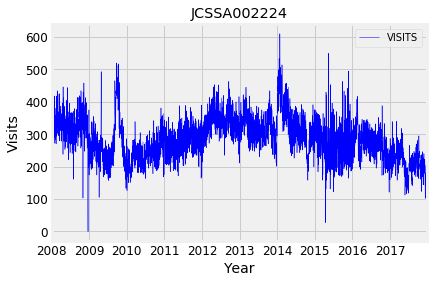

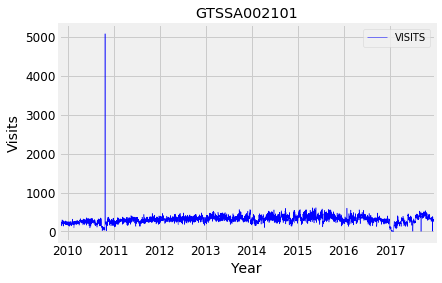

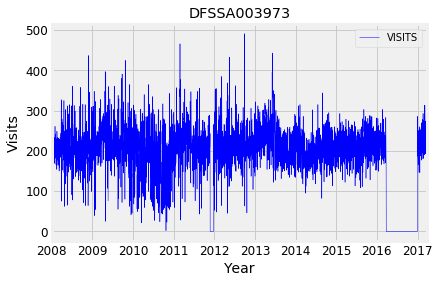

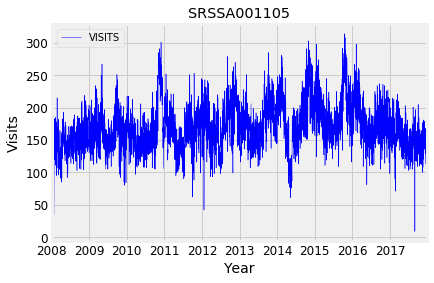

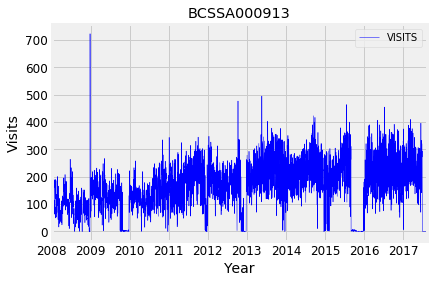

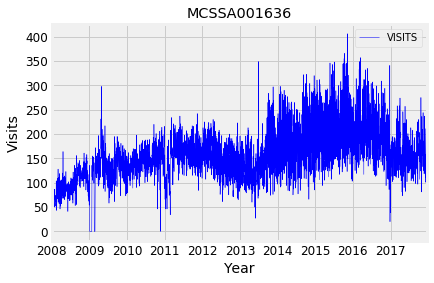

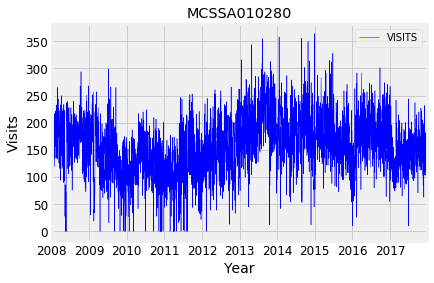

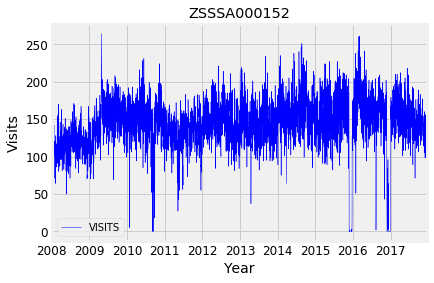

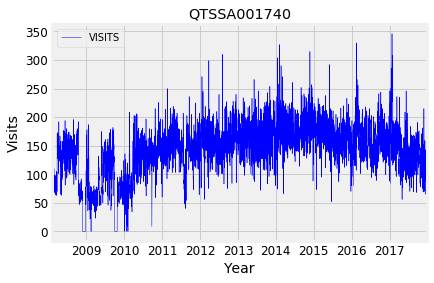

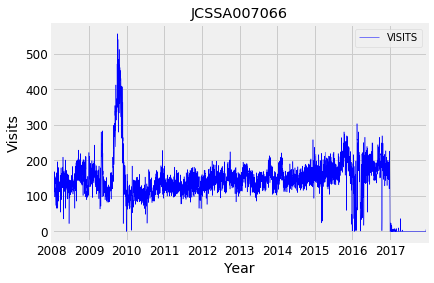

In [8]:
pd.plotting.register_matplotlib_converters()
for i, h in enumerate(ts_hospitals):
    h.plot(linewidth=.5,color="blue").set(xlabel='Year', ylabel='Visits', title=hospitals[i])
    plt.show()

### Review of density plots to gain insight into structure of the data
* Most of the distributions are Gaussian
    * A little of left-shift in most cases
* Some of them (specially GTSSA002101) have an abnormal beavior due to outliers
* Some transformations might be required prior to modeling

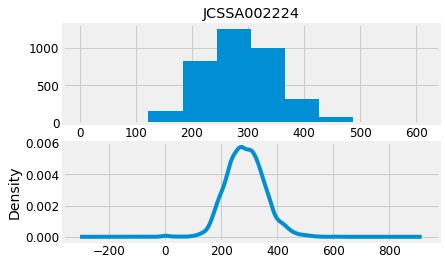

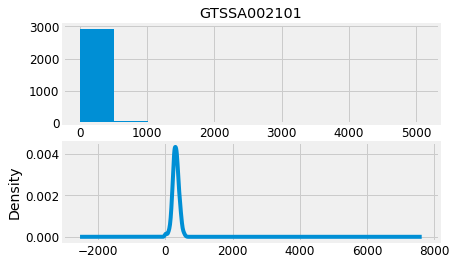

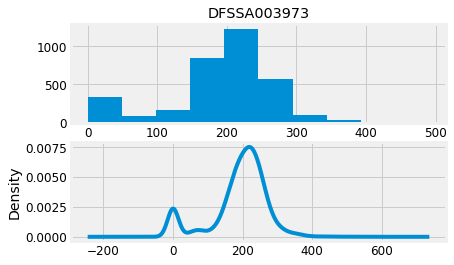

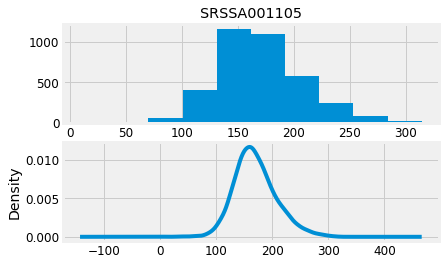

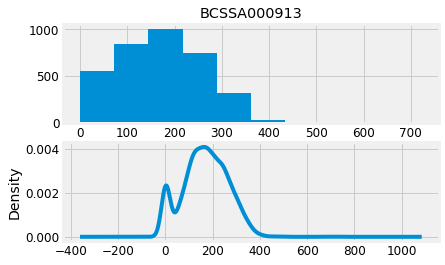

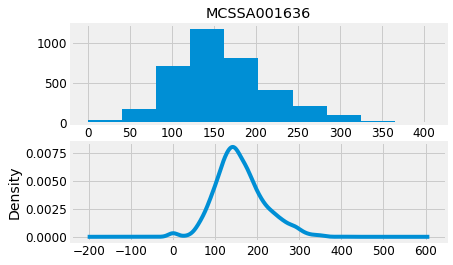

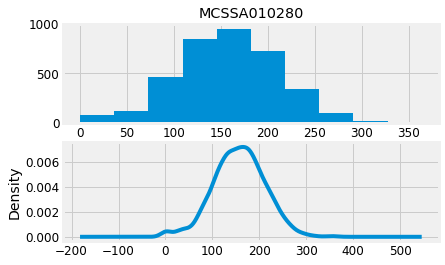

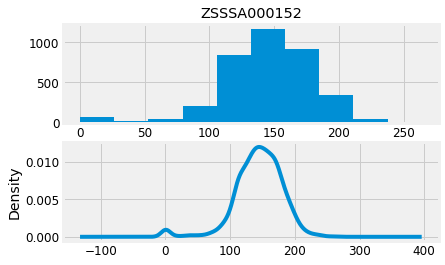

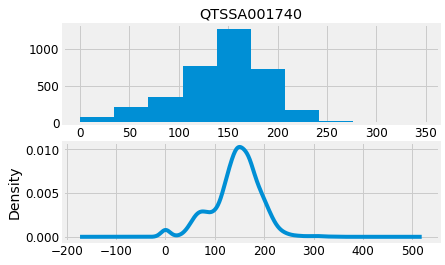

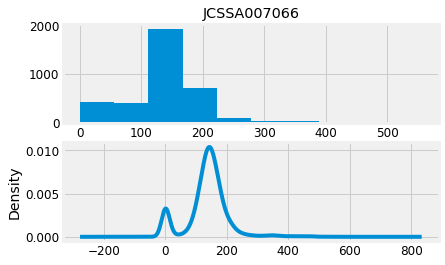

In [10]:
for i, h in enumerate(ts_hospitals):
    plt.figure(1)
    plt.subplot(211)
    h.VISITS.hist().set(title=hospitals[i])
    plt.subplot(212)
    h.VISITS.plot(kind='kde')
    plt.show()

### Use of box and whisker plots 
* No obvious seasonality or trend can be identified
* There is a high number of outliers
* Only some hospitals present steady increase in spread and increase in median values
    * This could be due to the tidyness of the data collection in said hospitals

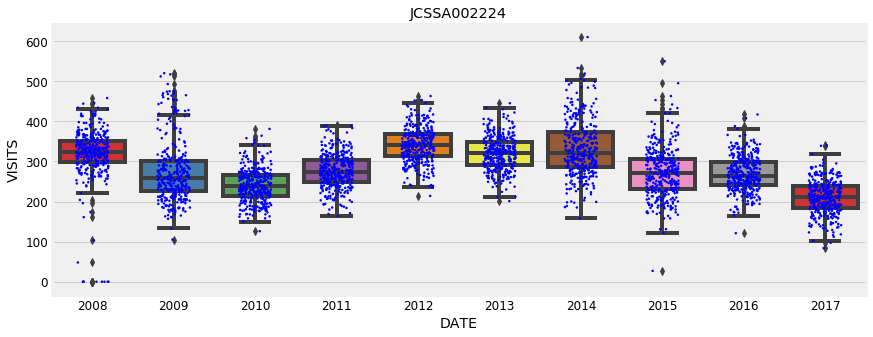

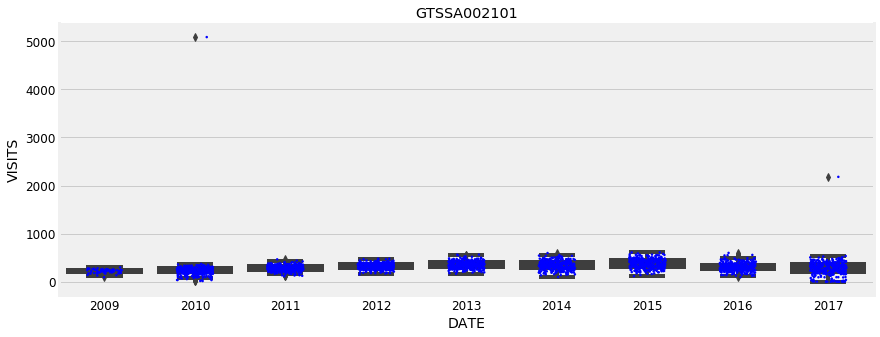

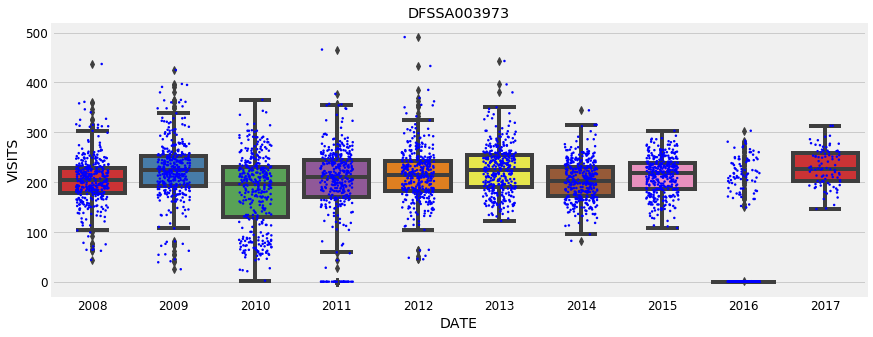

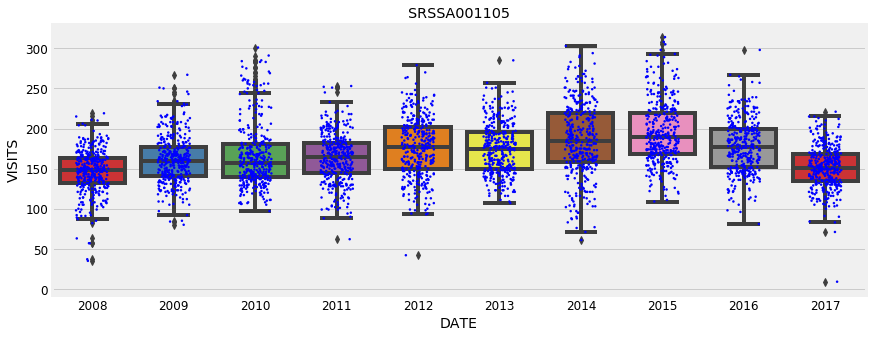

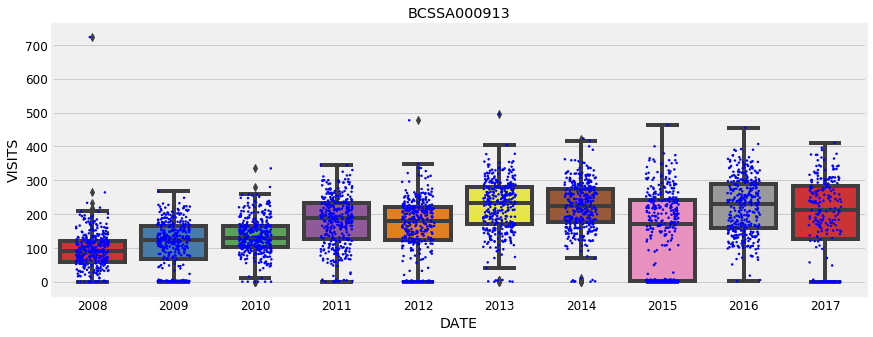

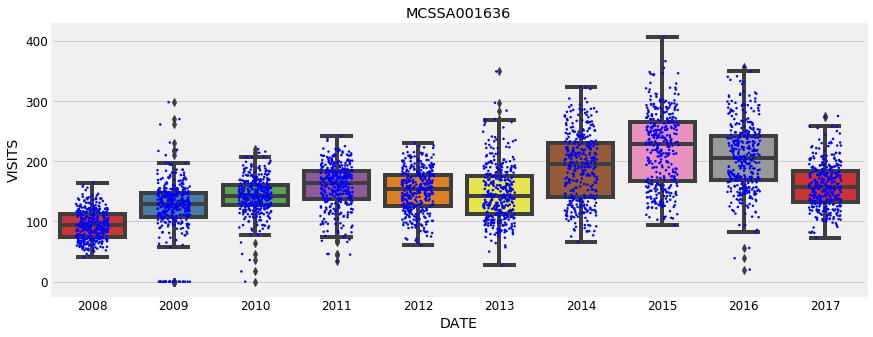

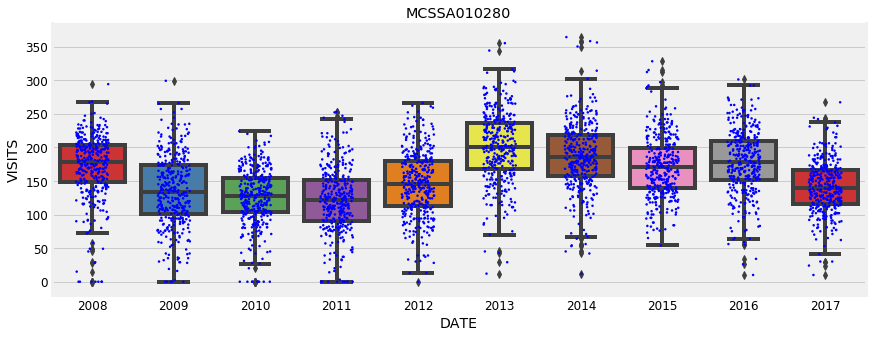

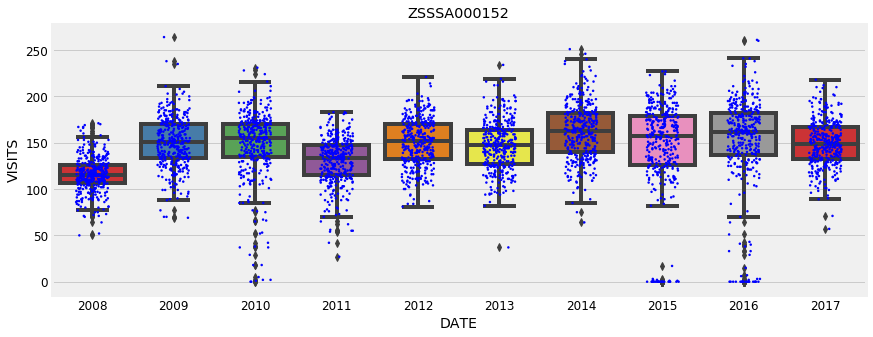

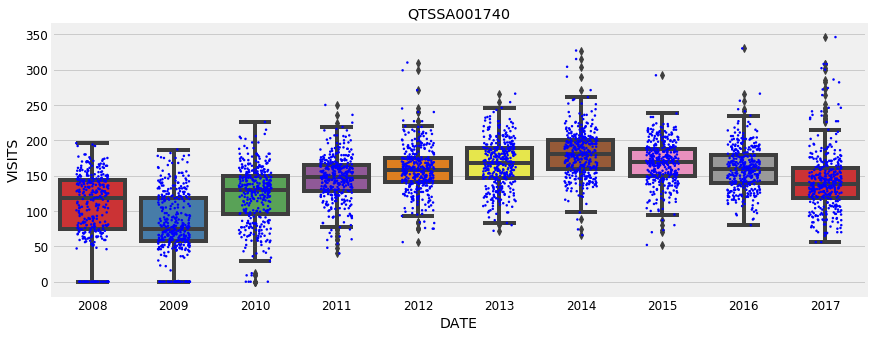

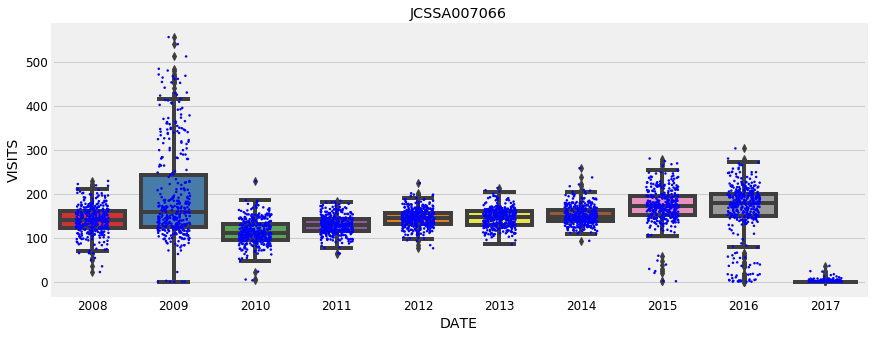

In [11]:
for i,y in enumerate(ts_hospitals):
    fig, ax = plt.subplots(figsize=(13,5))
    sns.boxplot(y.index.year, y.VISITS, ax=ax,palette="Set1" ).set(title=hospitals[i])
    sns.stripplot(y.index.year, y.VISITS, color="blue", jitter=0.2, size=2.5)

### Decomposition of Time series using statsmodels
   * We must decompose each time series to be able to isolate it into its base components/categories
   * Objective is to find trend, seasonality and noise.
       * Secondary objective is to find if TS is stationary

In [12]:
for h in ts_hospitals:
    display(h.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2008-01-01 to 2017-12-31
Freq: D
Data columns (total 1 columns):
VISITS    3653 non-null float64
dtypes: float64(1)
memory usage: 217.1 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2983 entries, 2009-10-26 to 2017-12-25
Freq: D
Data columns (total 1 columns):
VISITS    2983 non-null float64
dtypes: float64(1)
memory usage: 126.6 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3378 entries, 2008-01-01 to 2017-03-31
Freq: D
Data columns (total 1 columns):
VISITS    3378 non-null float64
dtypes: float64(1)
memory usage: 212.8 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2008-01-01 to 2017-12-31
Freq: D
Data columns (total 1 columns):
VISITS    3653 non-null int64
dtypes: int64(1)
memory usage: 217.1 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3517 entries, 2008-01-01 to 2017-08-17
Freq: D
Data columns (total 1 columns):
VISITS    3517 non-null float64
dtypes: float64(1)
memory usage: 215.0 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3647 entries, 2008-01-01 to 2017-12-25
Freq: D
Data columns (total 1 columns):
VISITS    3647 non-null float64
dtypes: float64(1)
memory usage: 217.0 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2008-01-01 to 2017-12-31
Freq: D
Data columns (total 1 columns):
VISITS    3653 non-null float64
dtypes: float64(1)
memory usage: 217.1 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3647 entries, 2008-01-01 to 2017-12-25
Freq: D
Data columns (total 1 columns):
VISITS    3647 non-null float64
dtypes: float64(1)
memory usage: 217.0 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3622 entries, 2008-02-01 to 2017-12-31
Freq: D
Data columns (total 1 columns):
VISITS    3622 non-null float64
dtypes: float64(1)
memory usage: 216.6 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3653 entries, 2008-01-01 to 2017-12-31
Freq: D
Data columns (total 1 columns):
VISITS    3653 non-null float64
dtypes: float64(1)
memory usage: 217.1 KB


None

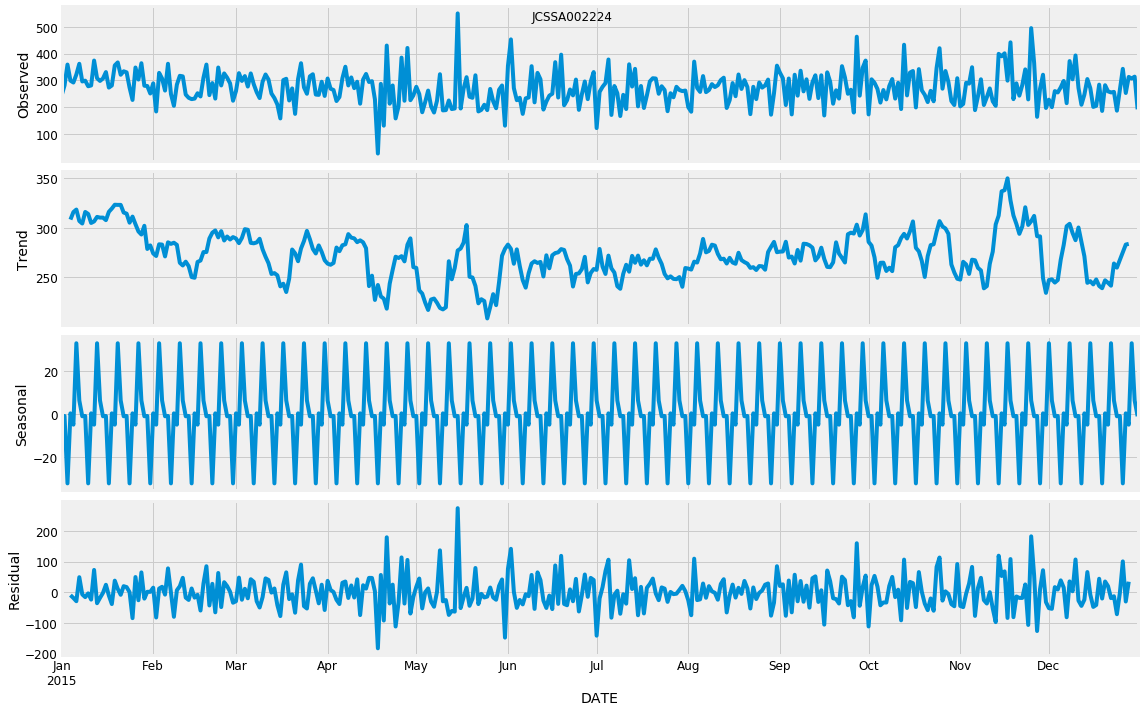

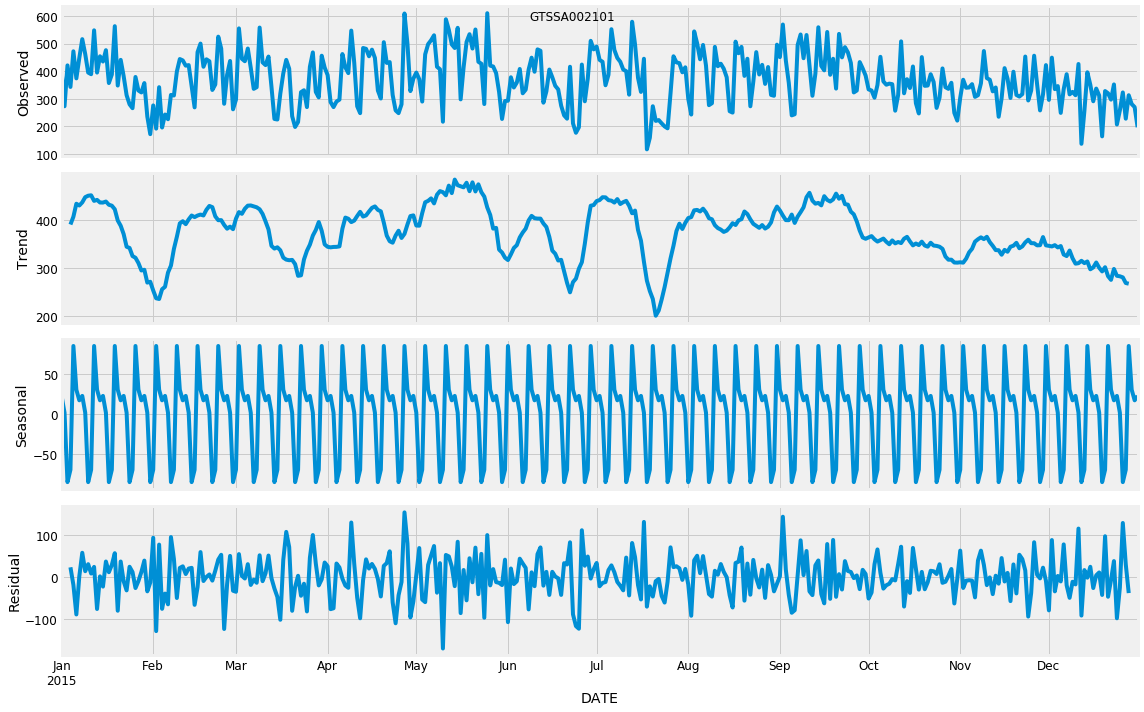

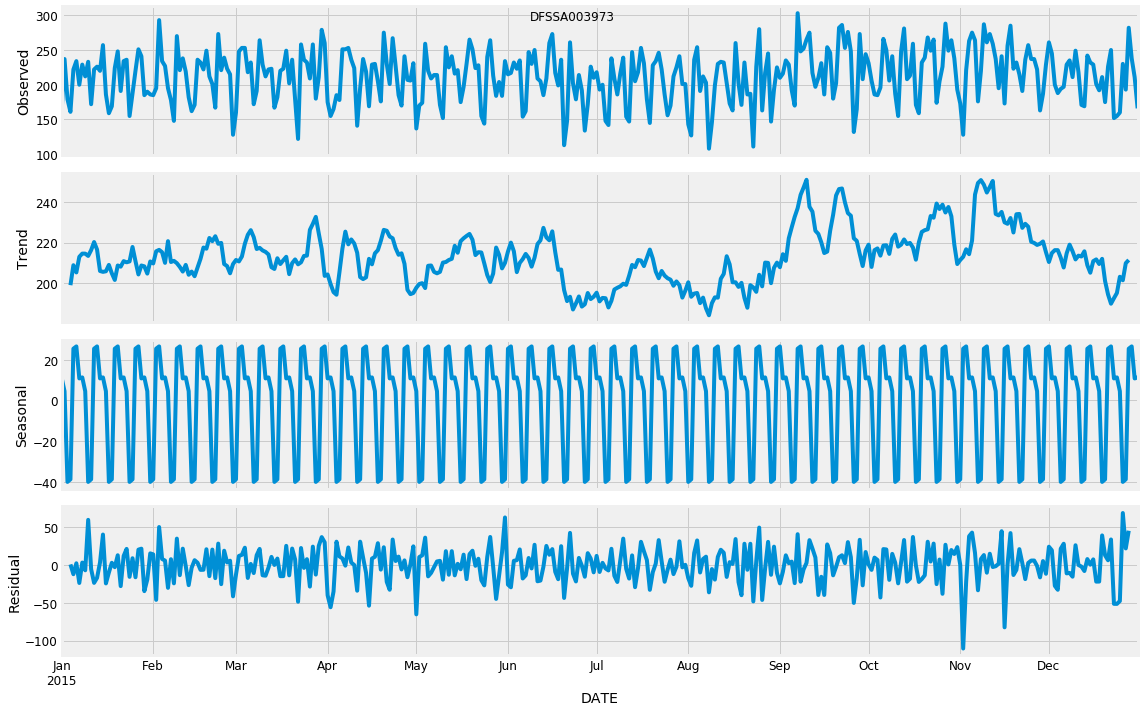

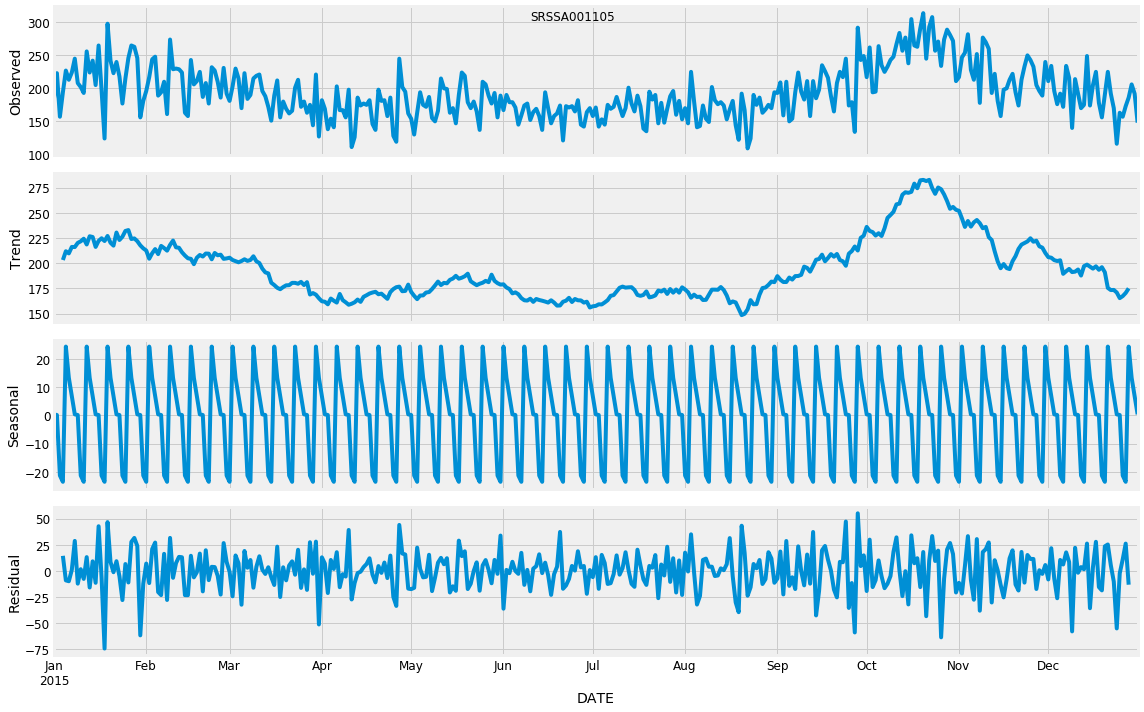

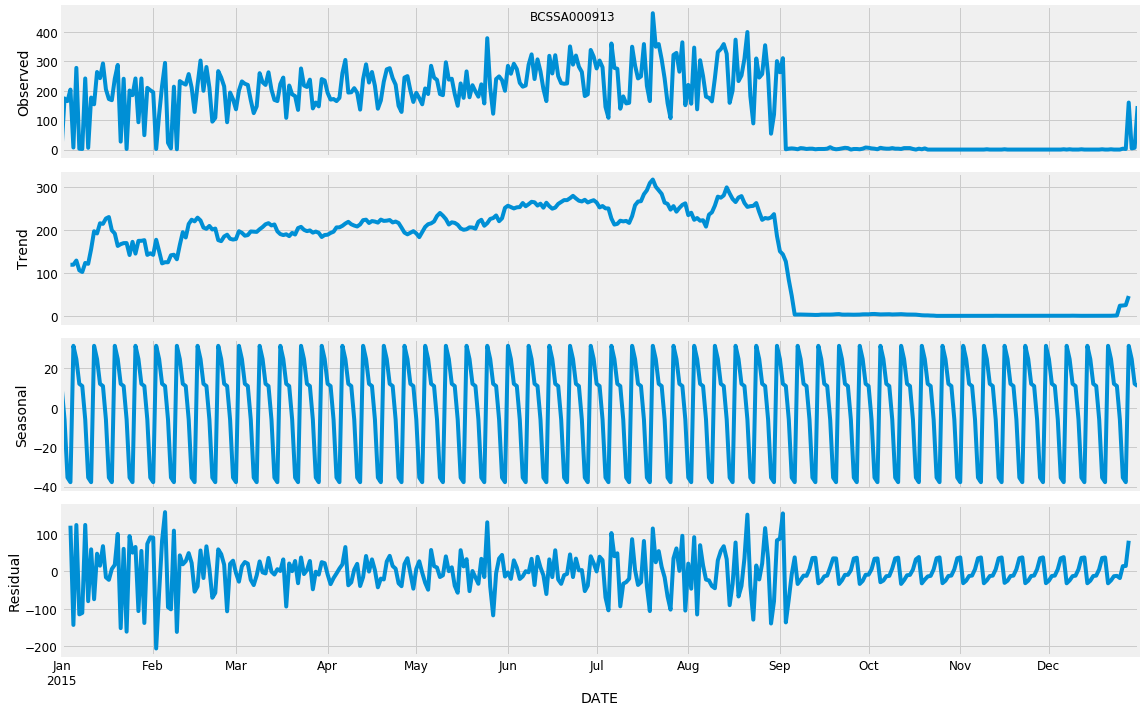

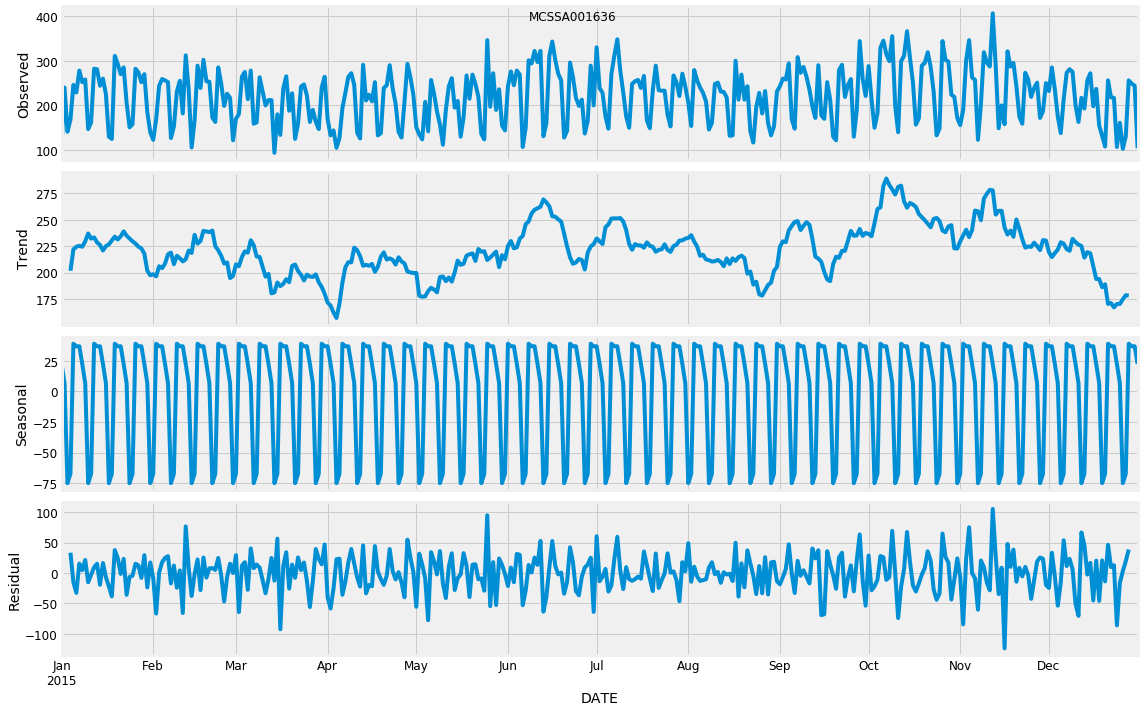

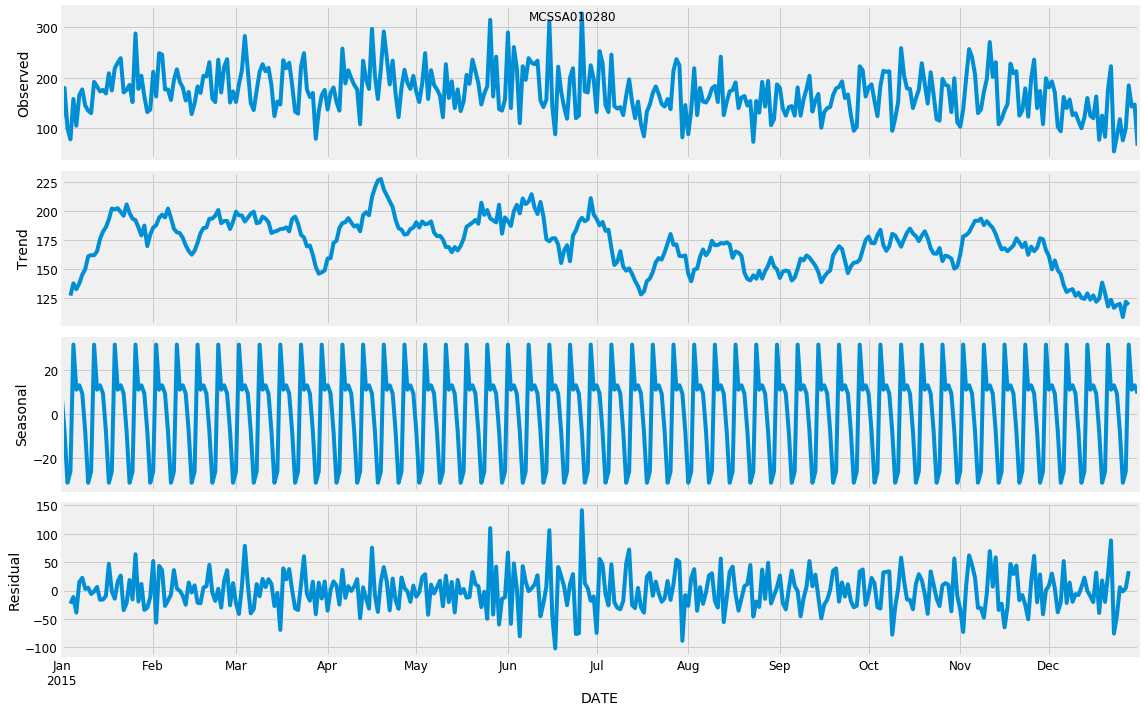

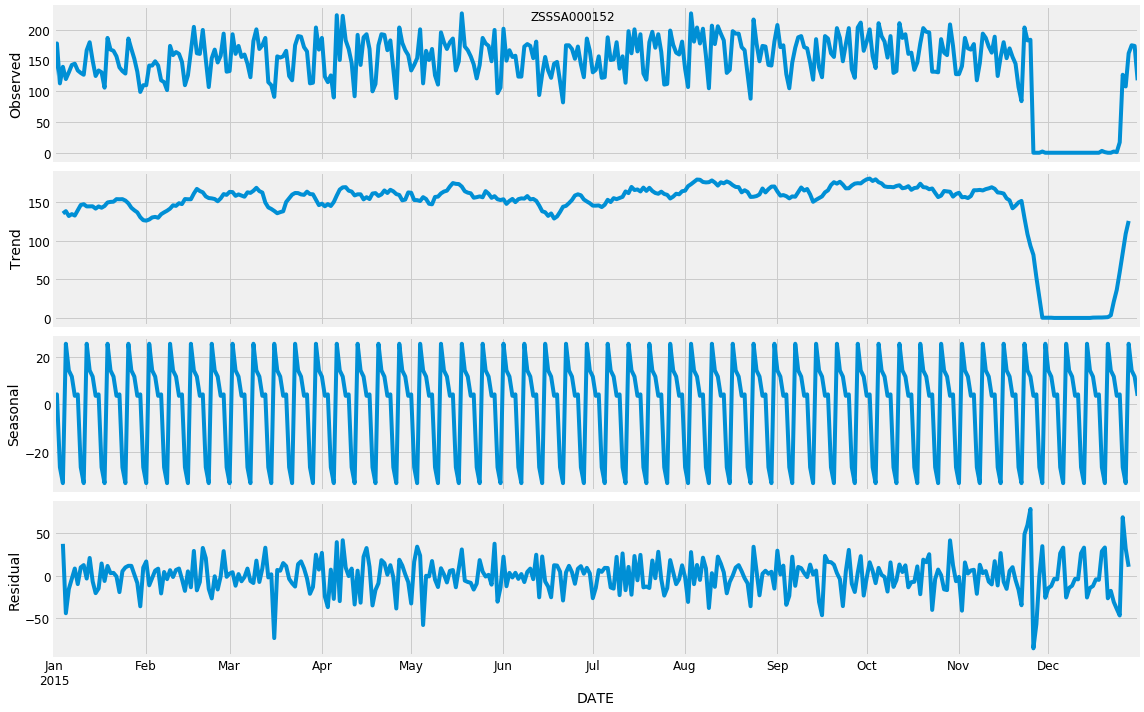

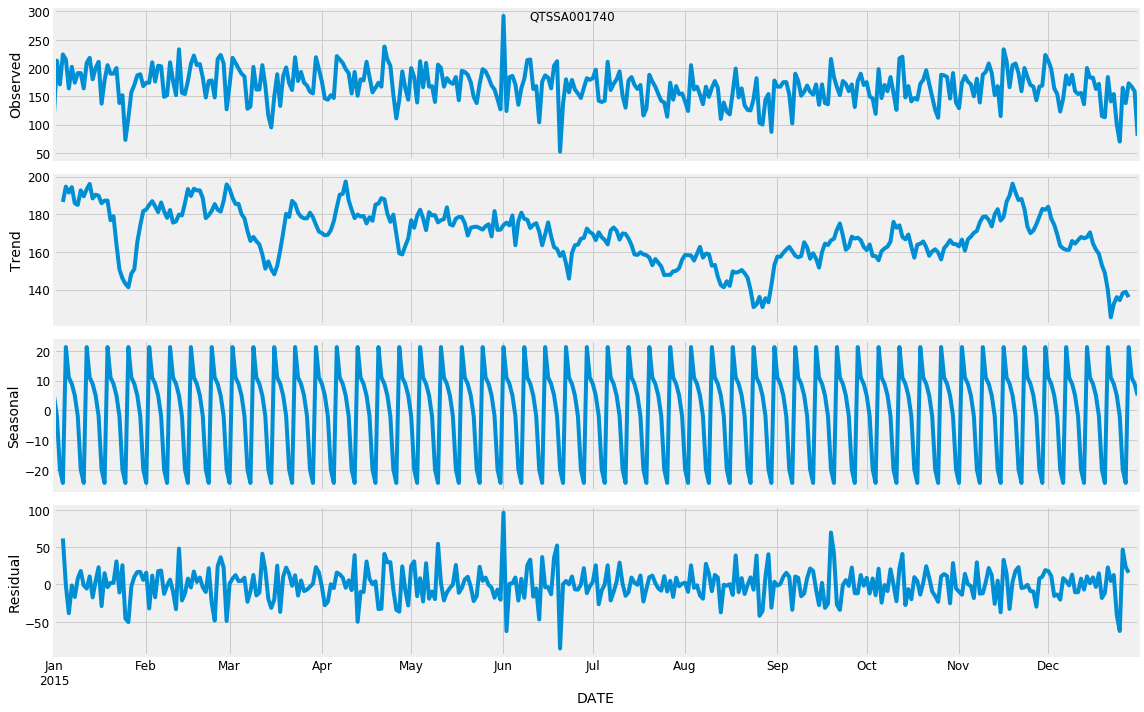

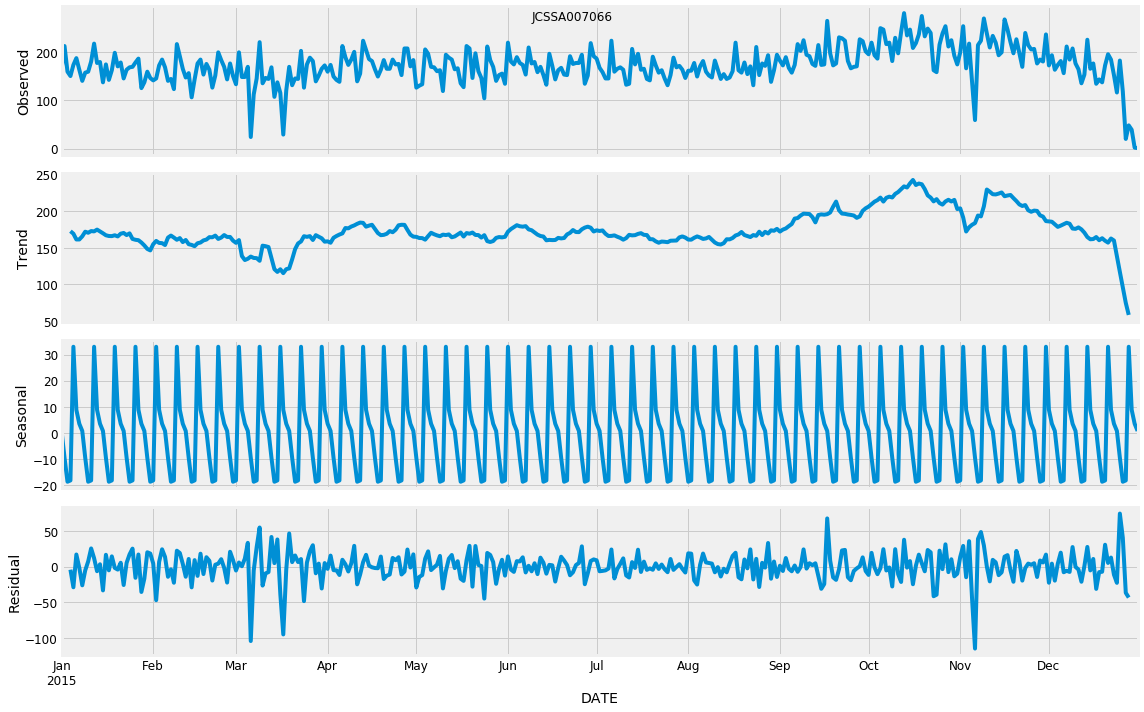

In [13]:
for i,h in enumerate(ts_hospitals):
    rcParams['figure.figsize'] = 16, 10
    decomposition = sm.tsa.seasonal_decompose(h['2015'], model='additive')
    fig = decomposition.plot()
    fig.suptitle(hospitals[i])
    fig.tight_layout()
    plt.show()

'JCSSA002224'

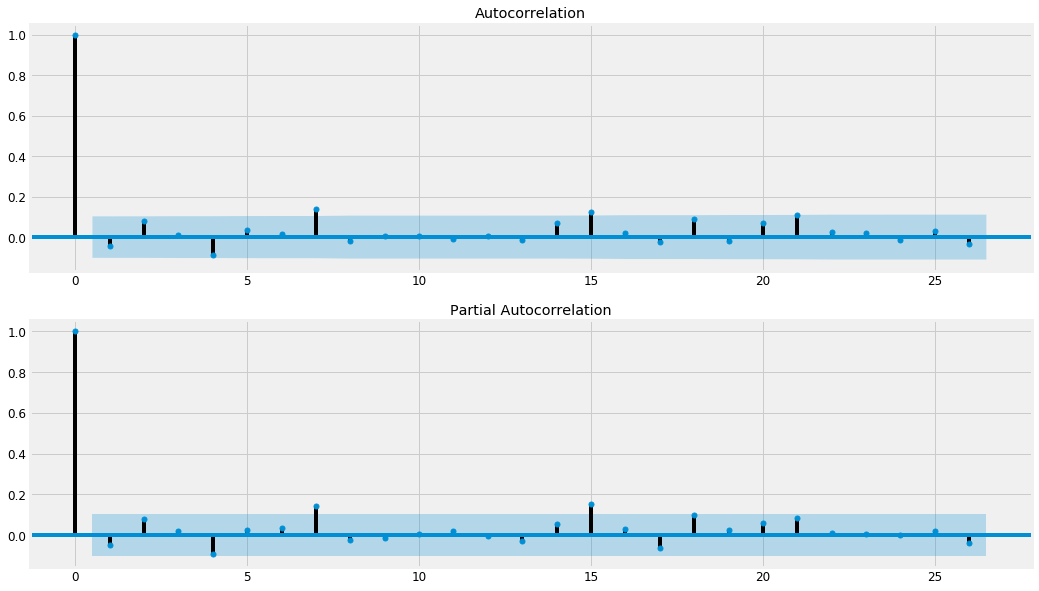

'GTSSA002101'

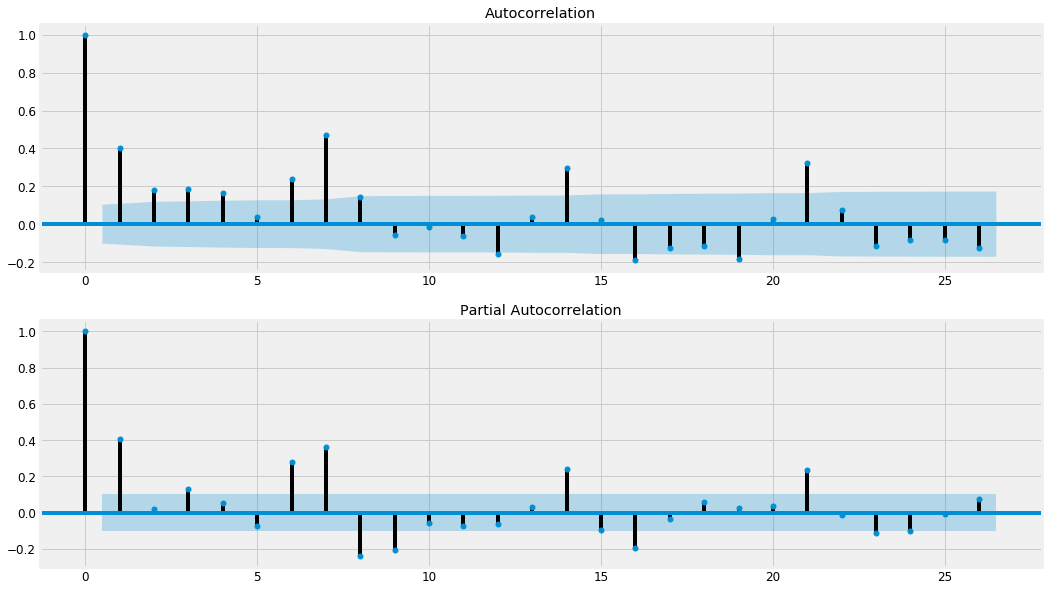

'DFSSA003973'

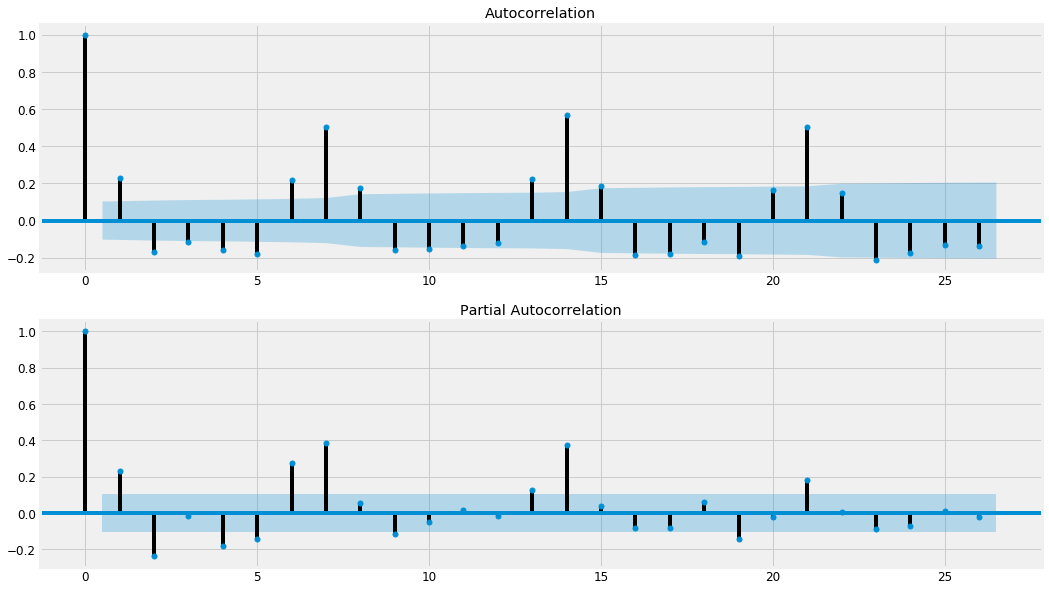

'SRSSA001105'

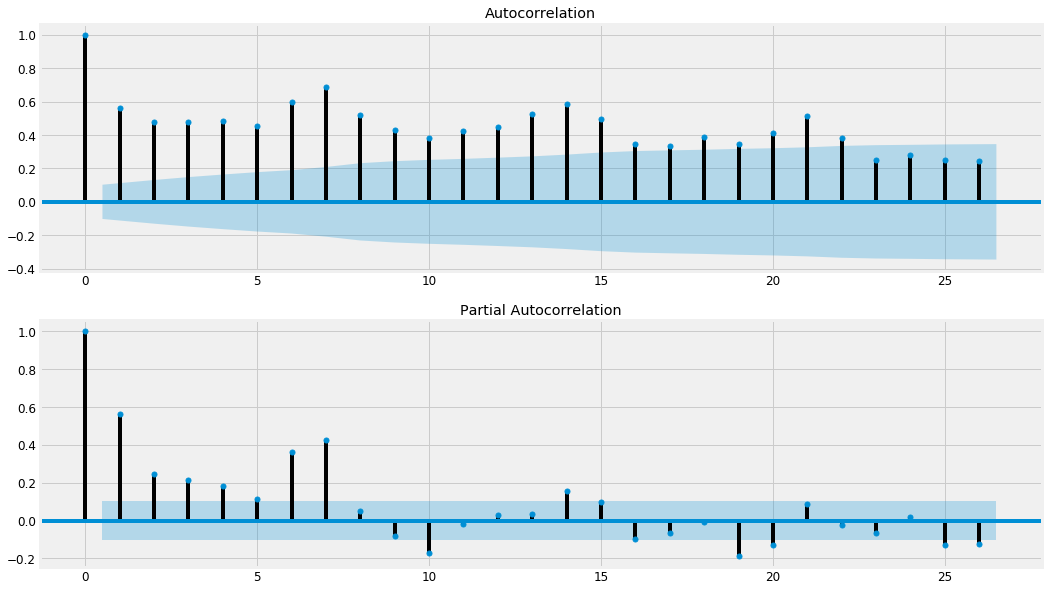

'BCSSA000913'

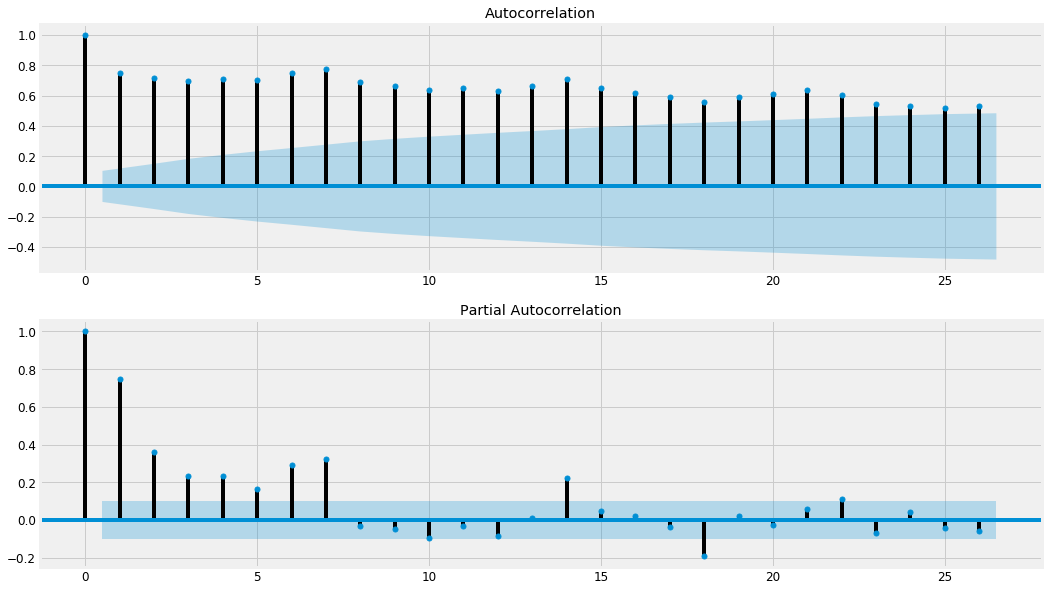

'MCSSA001636'

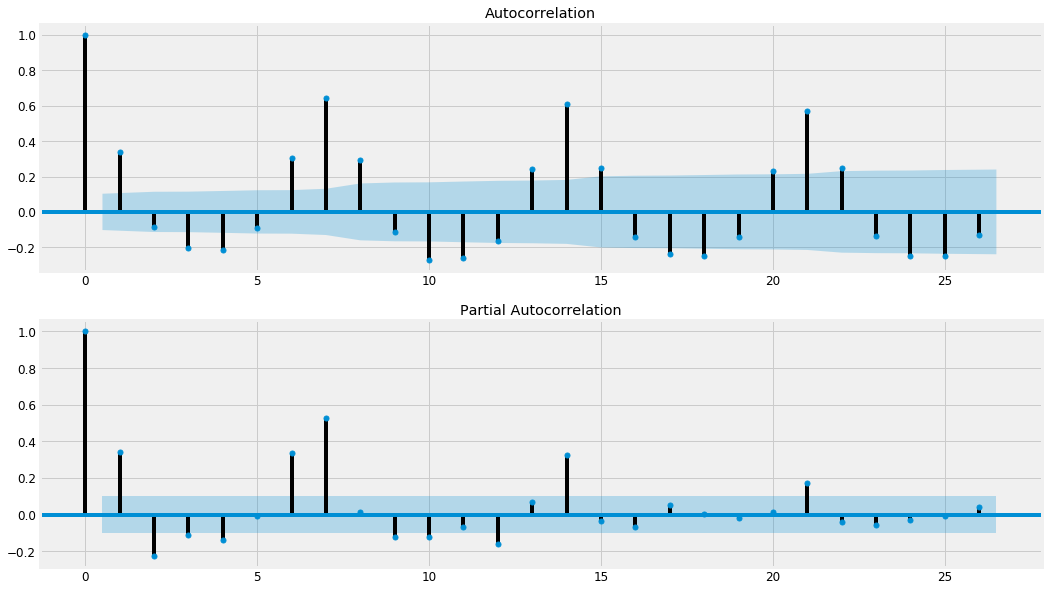

'MCSSA010280'

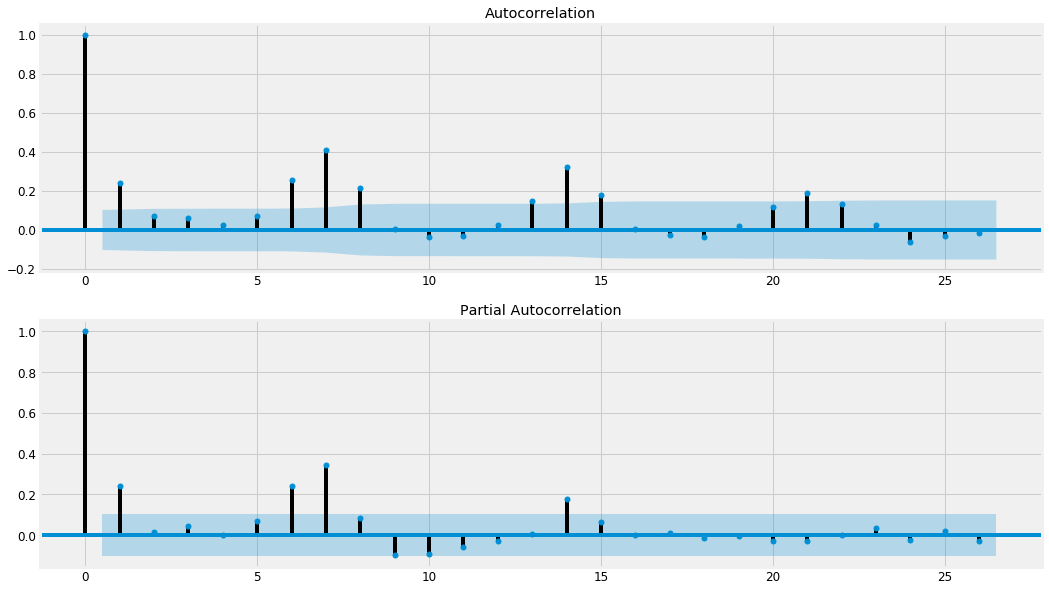

'ZSSSA000152'

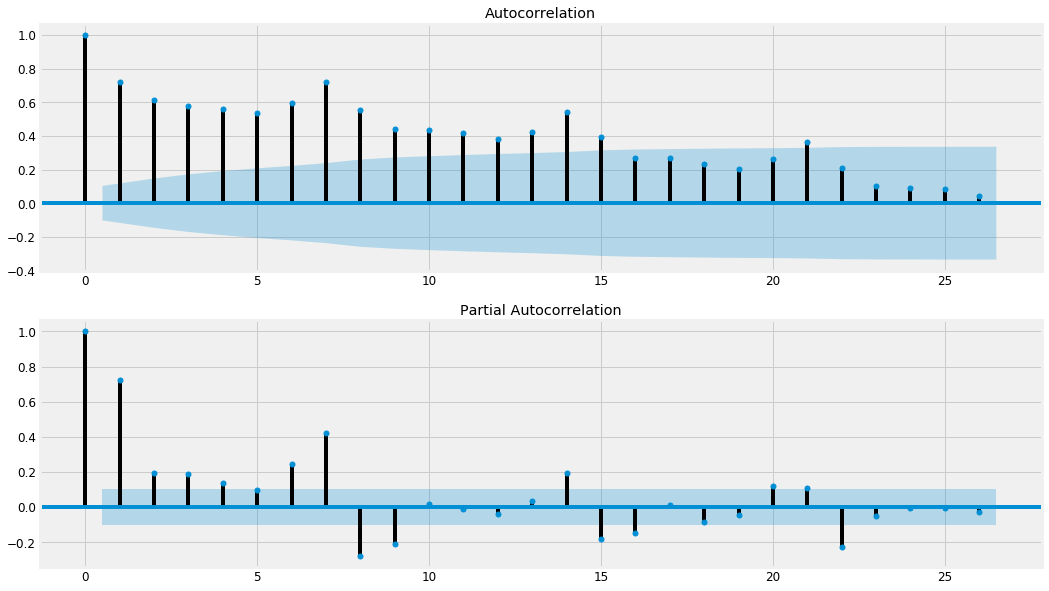

'QTSSA001740'

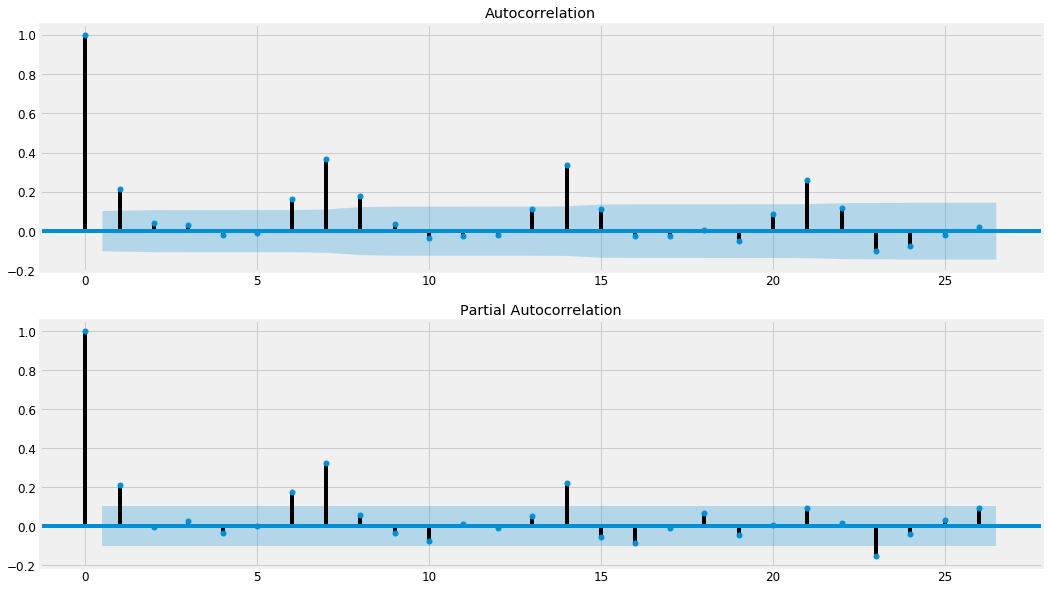

'JCSSA007066'

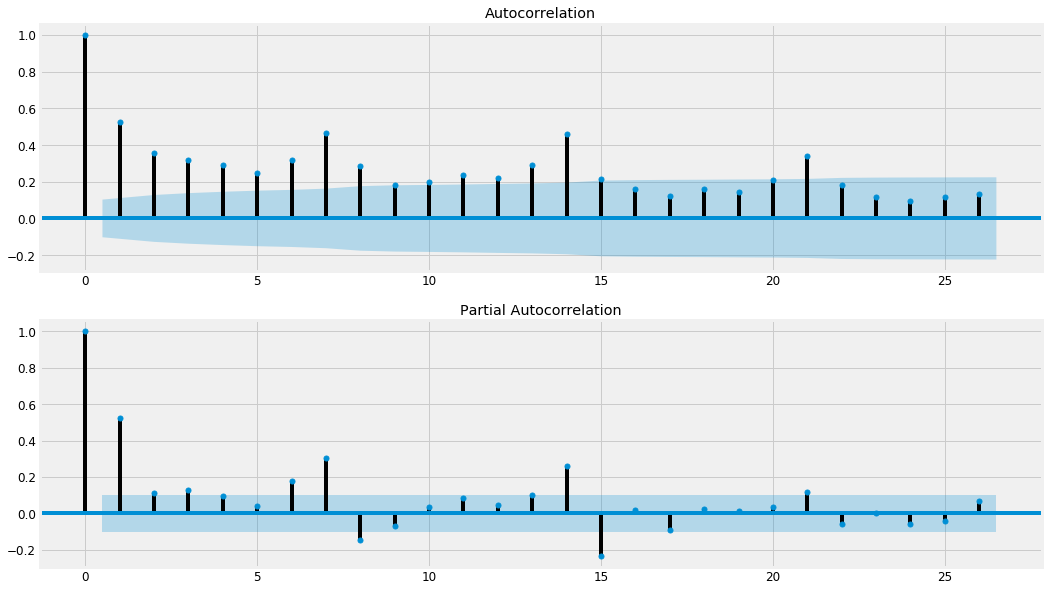

In [14]:
for i, h in enumerate(ts_hospitals):
    display(hospitals[i])
    plt.figure()
    fig.suptitle(hospitals[i])
    plt.subplot(211)
    plot_acf(h['2015'], ax=plt.gca())
    plt.subplot(212)
    plot_pacf(h['2015'], ax=plt.gca())
    plt.show()

----------------

## Rolling Statistics
    Since mean and standard deviation are not constant through time the TS is not stationary

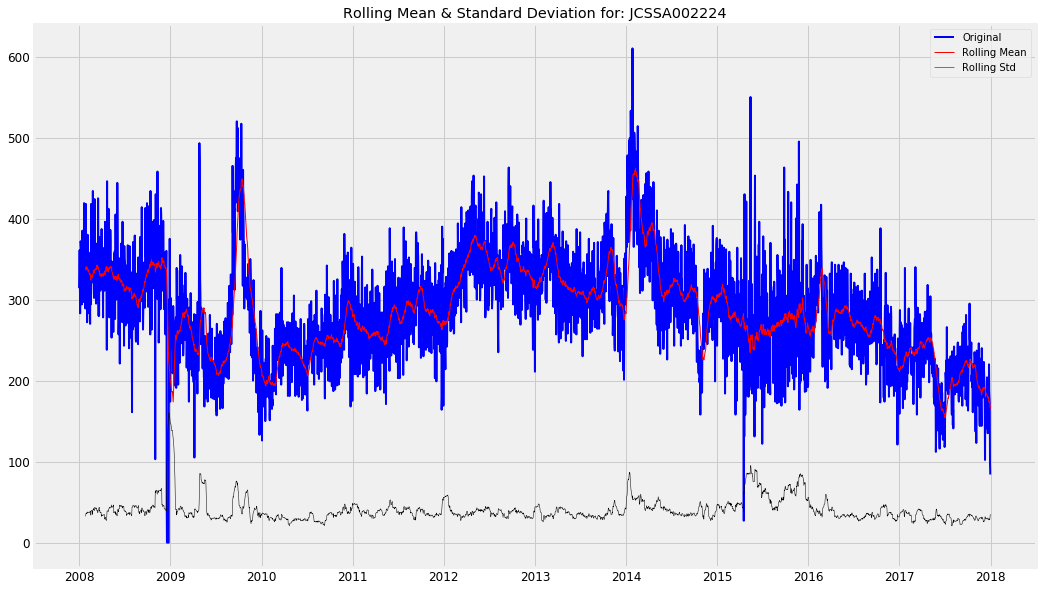

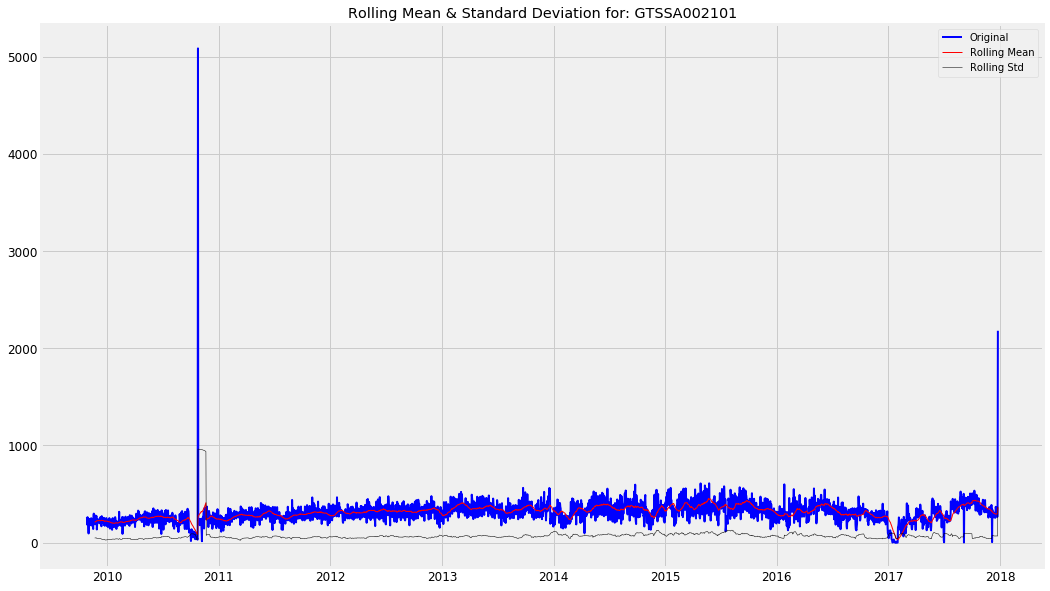

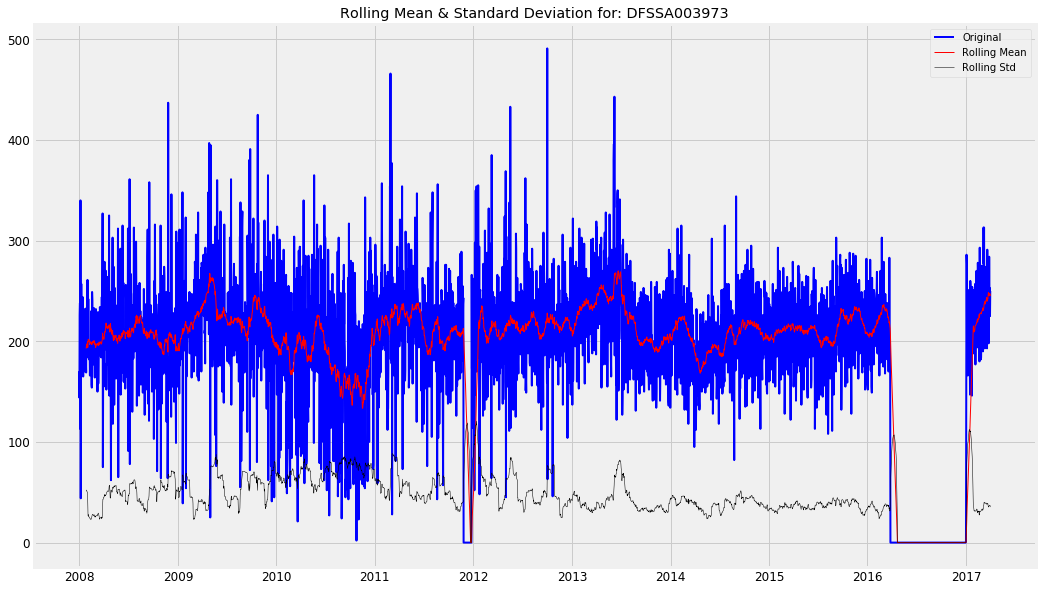

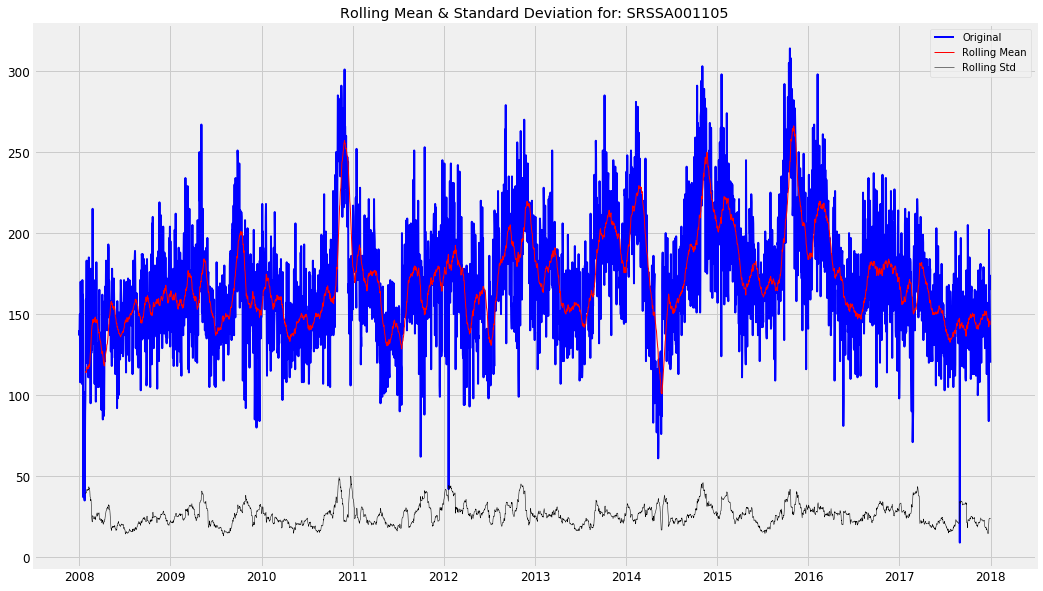

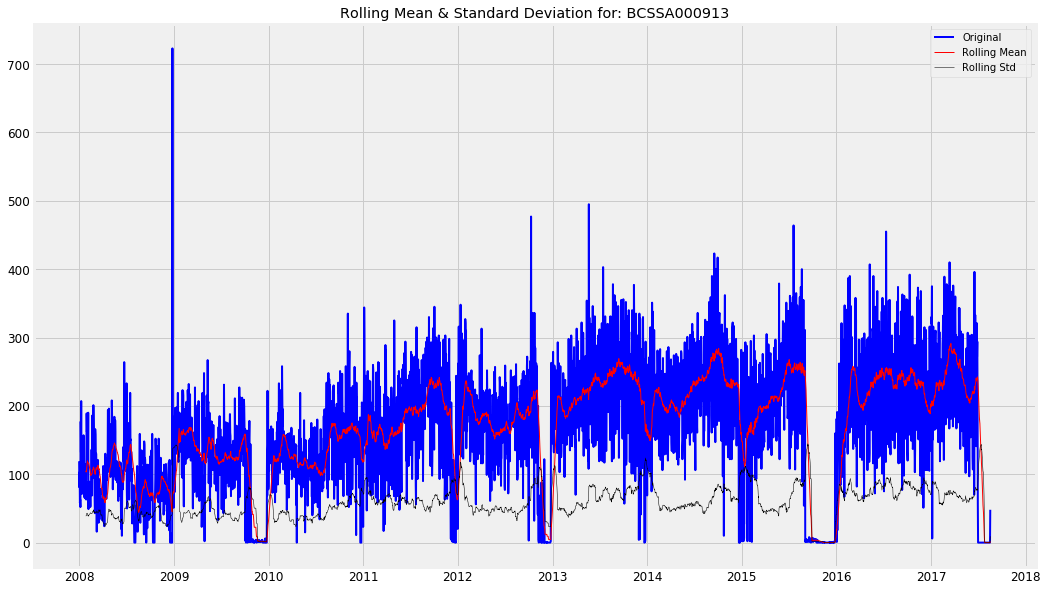

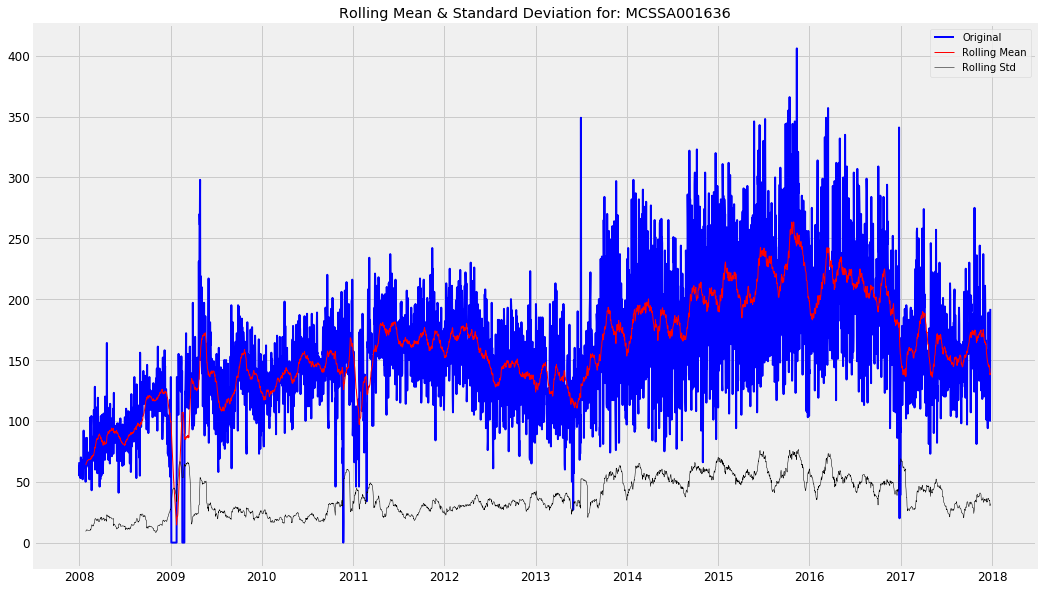

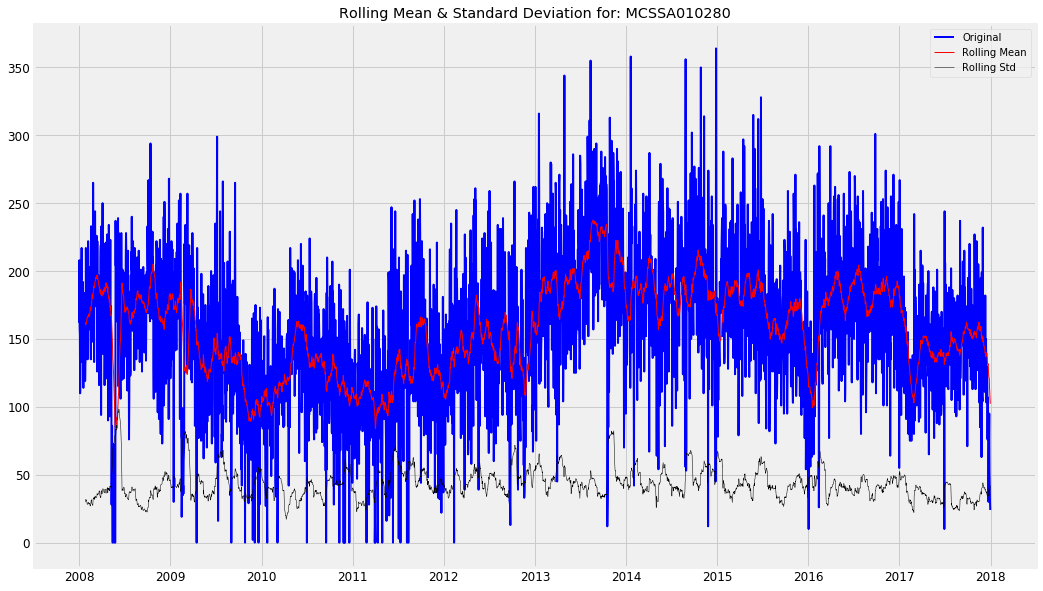

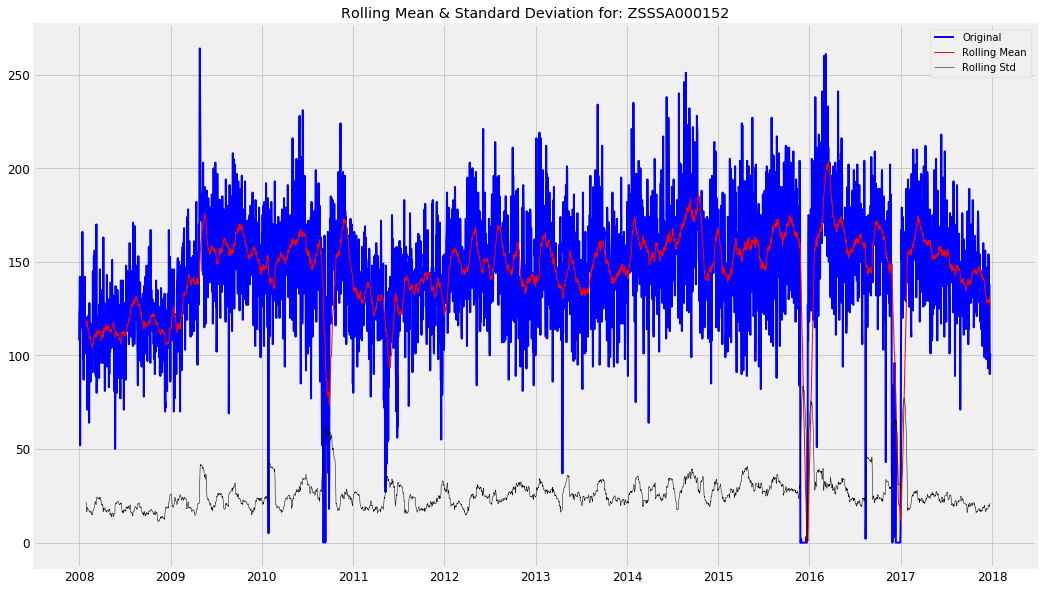

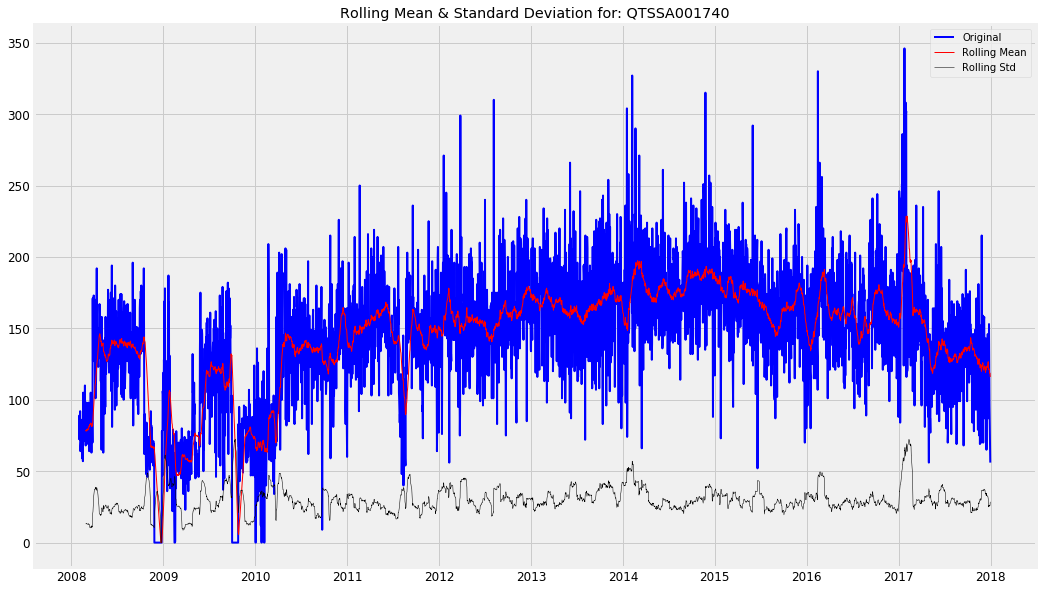

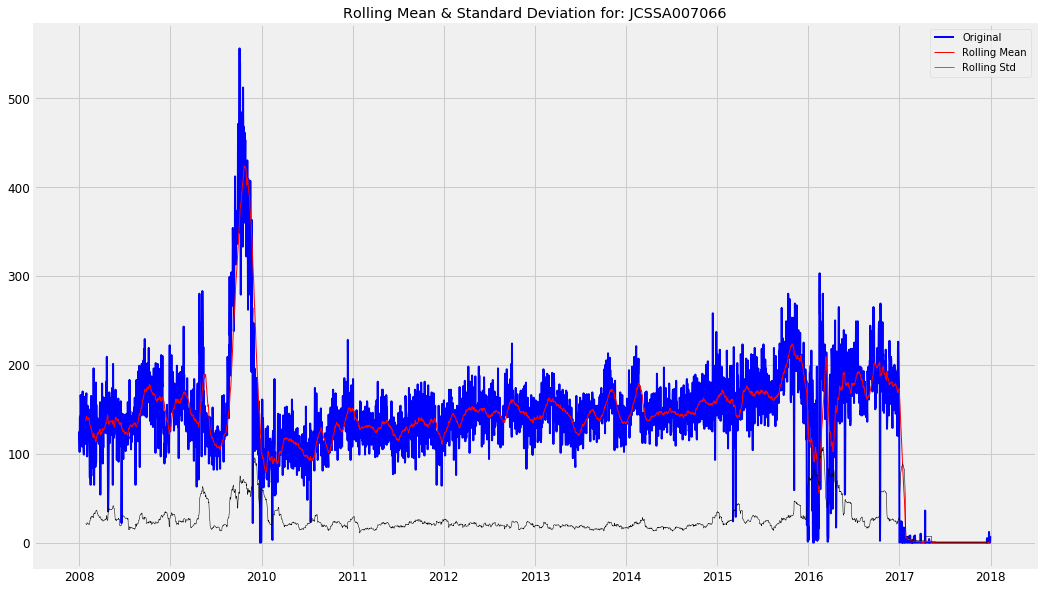

In [15]:
for i,y in enumerate(ts_hospitals):
    #Determing rolling statistics
    rolmean = y.rolling(27).mean()
    rolstd = y.rolling(27).std()

    #Plot rolling statistics:
    orig = plt.plot(y, linewidth=2, color='blue',label='Original')
    mean = plt.plot(rolmean, linewidth=1, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, linewidth=.5, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for: '+hospitals[i])
    plt.show(block=False)

## Augmented Dickie-Fuller test

* The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1) will provide no relevant information in predicting the change in y(t).
* Null hypothesis: The time series is not stationary
* Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

|Results of Dickey-Fuller Test: |  |
    |---|----|
| Test Statistic              |     -2.369567 |
| p-value                     |      0.150511 |
| Lags Used                   |      8.000000 |
| Number of Observations Used |    461.000000 |
| Critical Value (1%)         |     -3.444615 |
| Critical Value (5%)         |     -2.867830 |
| Critical Value (10%)        |     -2.570120 |

# Are they stationary????

In [16]:
for i,h in enumerate(ts_hospitals):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test for: ' +hospitals[i])
    dftest = adfuller(h.VISITS, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    display(dfoutput)

Results of Dickey-Fuller Test for: JCSSA002224


Test Statistic                   -4.174798
p-value                           0.000727
#Lags Used                       29.000000
Number of Observations Used    3623.000000
Critical Value (1%)              -3.432156
Critical Value (5%)              -2.862338
Critical Value (10%)             -2.567195
dtype: float64

Results of Dickey-Fuller Test for: GTSSA002101


Test Statistic                   -4.798626
p-value                           0.000055
#Lags Used                       27.000000
Number of Observations Used    2955.000000
Critical Value (1%)              -3.432565
Critical Value (5%)              -2.862519
Critical Value (10%)             -2.567291
dtype: float64

Results of Dickey-Fuller Test for: DFSSA003973


Test Statistic                   -3.573536
p-value                           0.006288
#Lags Used                       27.000000
Number of Observations Used    3350.000000
Critical Value (1%)              -3.432304
Critical Value (5%)              -2.862403
Critical Value (10%)             -2.567229
dtype: float64

Results of Dickey-Fuller Test for: SRSSA001105


Test Statistic                   -5.245678
p-value                           0.000007
#Lags Used                       28.000000
Number of Observations Used    3624.000000
Critical Value (1%)              -3.432156
Critical Value (5%)              -2.862338
Critical Value (10%)             -2.567195
dtype: float64

Results of Dickey-Fuller Test for: BCSSA000913


Test Statistic                   -4.358357
p-value                           0.000351
#Lags Used                       29.000000
Number of Observations Used    3487.000000
Critical Value (1%)              -3.432227
Critical Value (5%)              -2.862369
Critical Value (10%)             -2.567211
dtype: float64

Results of Dickey-Fuller Test for: MCSSA001636


Test Statistic                   -3.306172
p-value                           0.014605
#Lags Used                       28.000000
Number of Observations Used    3618.000000
Critical Value (1%)              -3.432159
Critical Value (5%)              -2.862339
Critical Value (10%)             -2.567195
dtype: float64

Results of Dickey-Fuller Test for: MCSSA010280


Test Statistic                   -4.274743
p-value                           0.000491
#Lags Used                       29.000000
Number of Observations Used    3623.000000
Critical Value (1%)              -3.432156
Critical Value (5%)              -2.862338
Critical Value (10%)             -2.567195
dtype: float64

Results of Dickey-Fuller Test for: ZSSSA000152


Test Statistic                -7.499180e+00
p-value                        4.298732e-11
#Lags Used                     2.800000e+01
Number of Observations Used    3.618000e+03
Critical Value (1%)           -3.432159e+00
Critical Value (5%)           -2.862339e+00
Critical Value (10%)          -2.567195e+00
dtype: float64

Results of Dickey-Fuller Test for: QTSSA001740


Test Statistic                   -4.003416
p-value                           0.001393
#Lags Used                       30.000000
Number of Observations Used    3591.000000
Critical Value (1%)              -3.432172
Critical Value (5%)              -2.862345
Critical Value (10%)             -2.567199
dtype: float64

Results of Dickey-Fuller Test for: JCSSA007066


Test Statistic                   -3.704930
p-value                           0.004044
#Lags Used                       29.000000
Number of Observations Used    3623.000000
Critical Value (1%)              -3.432156
Critical Value (5%)              -2.862338
Critical Value (10%)             -2.567195
dtype: float64

## Define a method to re-do stationarity test further on

In [17]:
# we define a method to print the previous analysis on any univariate TS from ts_hospitals
def test_stationarity(timeseries,time_window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=time_window).mean()
    rolstd = timeseries.rolling(window=time_window).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original', linewidth=1)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=.8)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth=.8)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.VISITS, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Forecast quality scoring metrics
* R squared
* Median Absolute Error
* Mean Absolute Error
* Mean Squared Error
* Mean Squared Logarithmic Error
* Mean Absolute Percentage Error

In [18]:
## function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# function to evaluate forecast model
def evaluate_forecast(real,pred):
    results = pd.DataFrame({'r2_score':r2_score(real, pred),
                           }, index=[0])
    results['median_absolute_error'] = median_absolute_error(real, pred)
    results['mae'] = mean_absolute_error(real, pred)
    results['mse'] = mean_squared_error(real, pred)
    results['msle'] = mean_squared_log_error(real, pred)
    results['rmse'] = np.sqrt(results['mse'])
    results['mape'] = mean_absolute_percentage_error(real, pred)
    return results

-----------------
-------------
------------
# SPECIFIC TIME SERIES ANALYSIS AND FORECAST 

### Hospitals:

* JCSSA002224
* GTSSA002101
* DFSSA003973
* SRSSA001105
* BCSSA000913
* MCSSA001636
* MCSSA010280
* ZSSSA000152
* QTSSA001740
* JCSSA007066

---------------------
### resample data to weekly and redo plotting and decomposition
 * To see if seasonality changes or model benefits from grouping data
--------------

VISITS
count  470.000000
mean   155.766945
std     37.291291
min     47.857143
25%    128.750000
50%    155.142857
75%    185.142857
max    256.428571

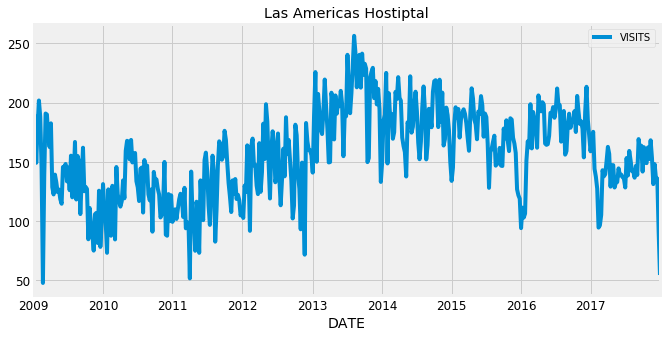

In [19]:
ts_weekly = ts_MCSSA010280['2009':].resample('W').mean()
ts_weekly.plot(figsize=(10,5), title="Las Americas Hostiptal")
ts_weekly.describe()

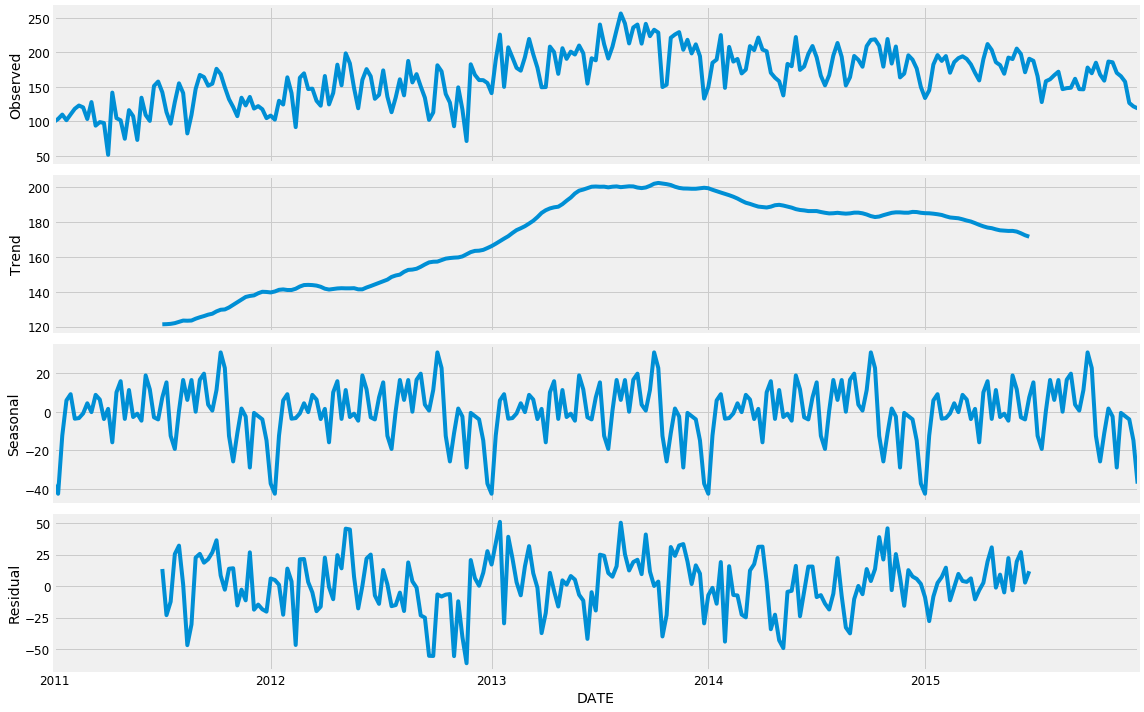

In [20]:
decomposition = sm.tsa.seasonal_decompose(ts_weekly['2011':'2015'], model='additive')
fig = decomposition.plot()
fig.tight_layout()
plt.show()

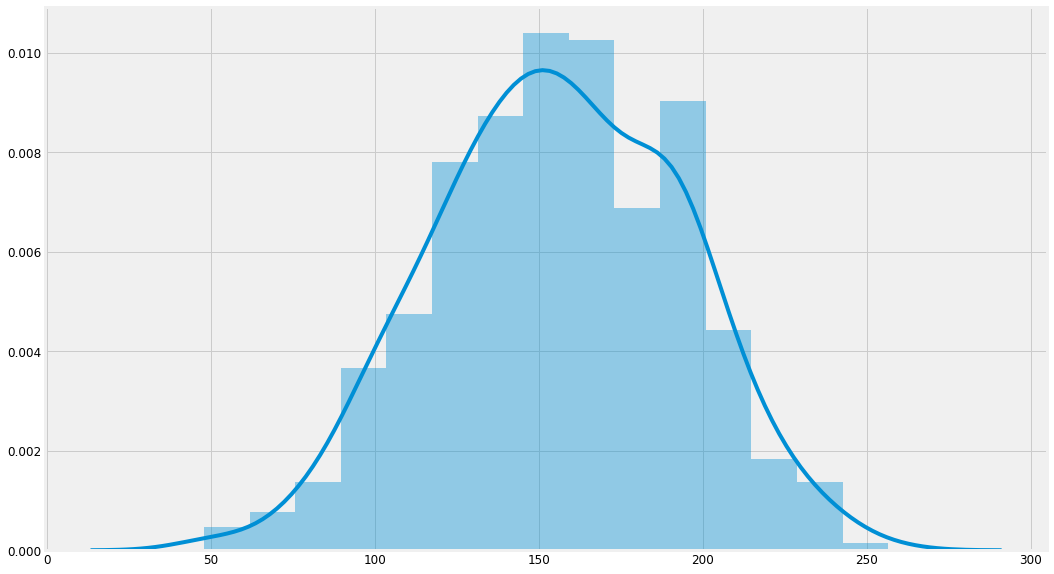

In [21]:
sns.distplot(ts_weekly, label="distribucion")

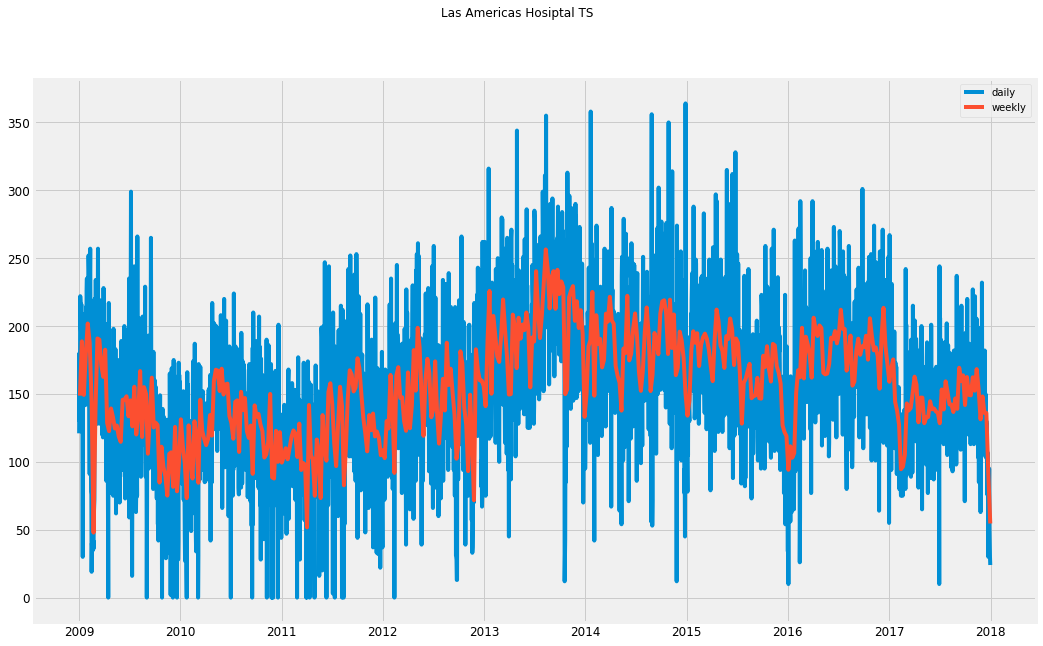

VISITS
count  470.000000
mean   155.766945
std     37.291291
min     47.857143
25%    128.750000
50%    155.142857
75%    185.142857
max    256.428571

VISITS
count  3287.000000
mean    155.773350
std      54.934815
min       0.000000
25%     119.000000
50%     155.000000
75%     191.000000
max     364.000000

In [22]:
daily, = plt.plot(ts_MCSSA010280['2009':], label="daily")
weekly, = plt.plot(ts_MCSSA010280['2009':].resample('W').mean(), label="weekly")
plt.legend(handles=[daily,weekly])
plt.suptitle("Las Americas Hosiptal TS")
plt.show()
display(ts_weekly.describe())
display(ts_MCSSA010280['2009':].describe())

----------------
###### Change subj for any weekly transformed TS to see predictions. 
* AR, MA, ARMA, ARIMA and SARIMA must be tuned according to the TS

In [23]:
# subj = ts_JCSSA002224
# subj = ts_MCSSA010280
subj = ts_weekly
tim_window = 8

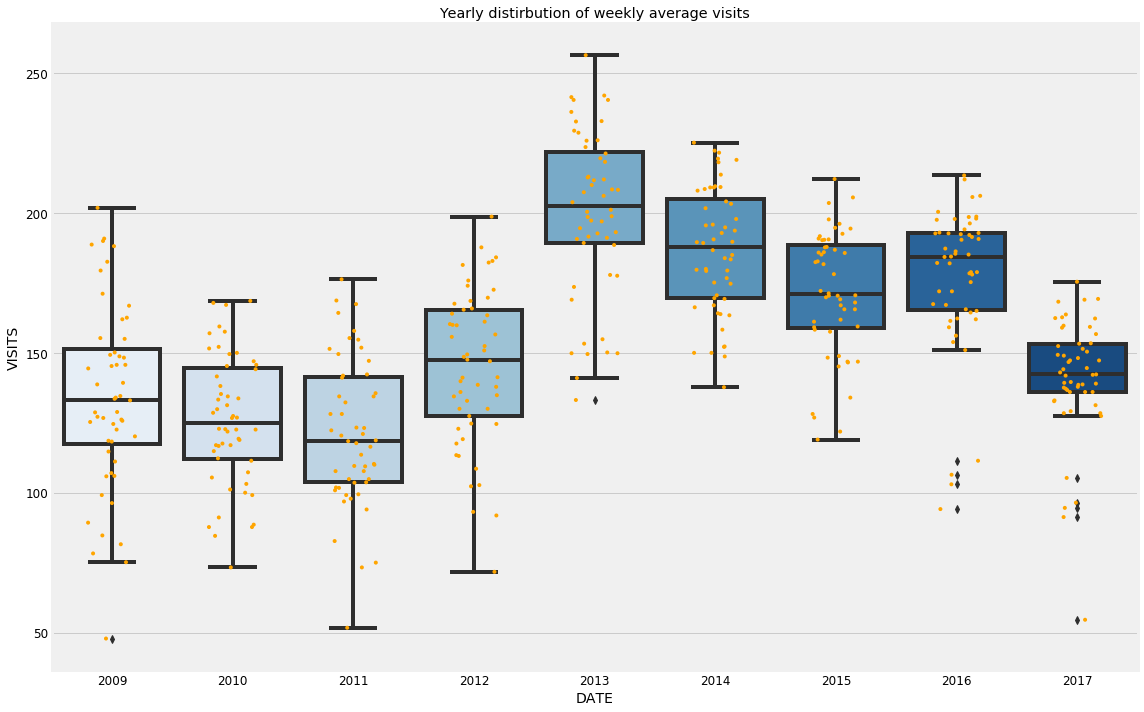

(470, 1)

In [24]:
b = sns.boxplot(subj.index.year, subj.VISITS, palette="Blues")
b = sns.stripplot(subj.index.year,subj.VISITS, color="orange", jitter=0.2, size=4)
# b.set_xticklabels(hospitals[2:], rotation=-90)
b.set_title(label="Yearly distirbution of weekly average visits")
plt.tight_layout()
plt.show(b)
display(subj.shape)
## z score outlier detection
# ind = subj[(np.abs(stats.zscore(subj['VISITS'])) > 3)]
# ind.shape

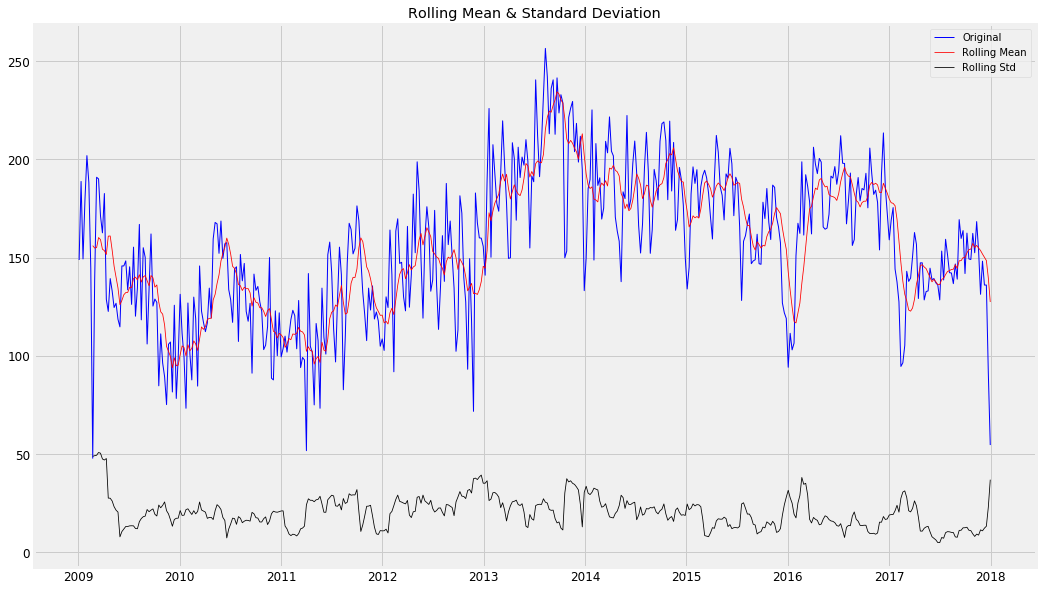

Results of Dickey-Fuller Test:
Test Statistic                  -2.369567
p-value                          0.150511
#Lags Used                       8.000000
Number of Observations Used    461.000000
Critical Value (1%)             -3.444615
Critical Value (5%)             -2.867830
Critical Value (10%)            -2.570120
dtype: float64


In [25]:
test_stationarity(subj, tim_window)

In [26]:
H, c,data = hurst.compute_Hc(subj)
print("H = {:.4f}, c = {:.4f}".format(H,c))

H = 0.2825, c = 1.4221


In [27]:
# ['JCSSA002224',
#  'GTSSA002101',
#  'DFSSA003973',
#  'SRSSA001105',
#  'BCSSA000913',
#  'MCSSA001636',
#  'MCSSA010280',
#  'ZSSSA000152',
#  'QTSSA001740',
#  'JCSSA007066']

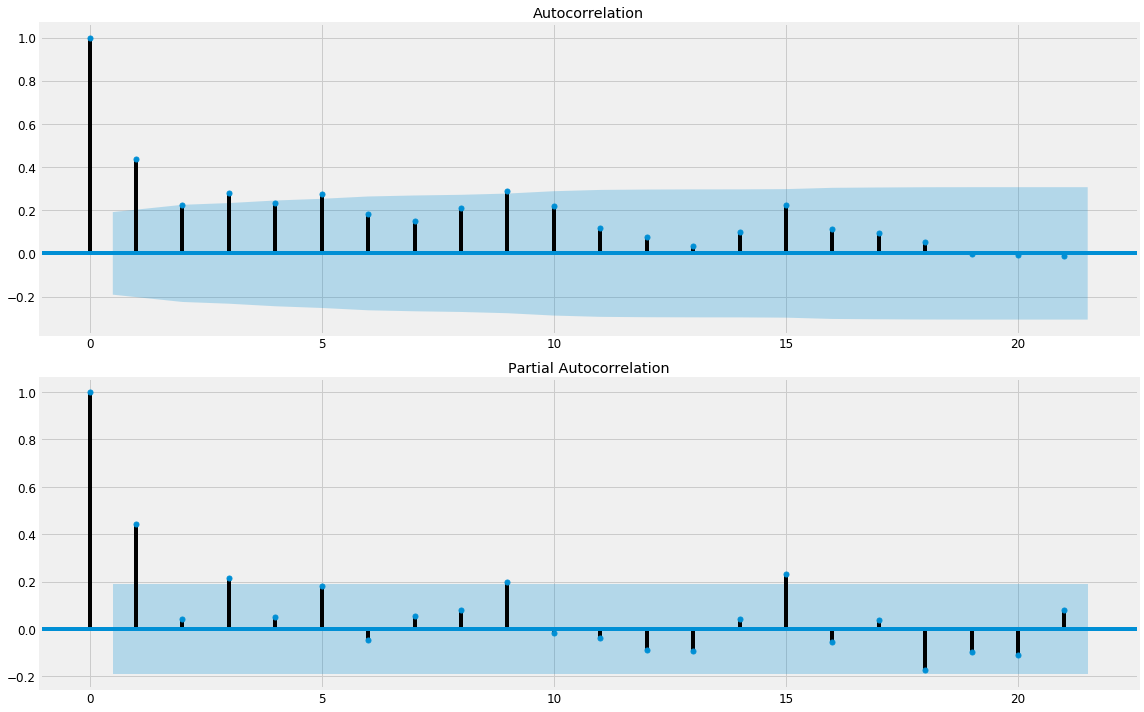

In [28]:
plt.figure()
plt.subplot(211)
plot_acf(subj['2011':'2012'], ax=plt.gca())
plt.subplot(212)
plot_pacf(subj['2011':'2012'], ax=plt.gca())
plt.tight_layout()
plt.show()

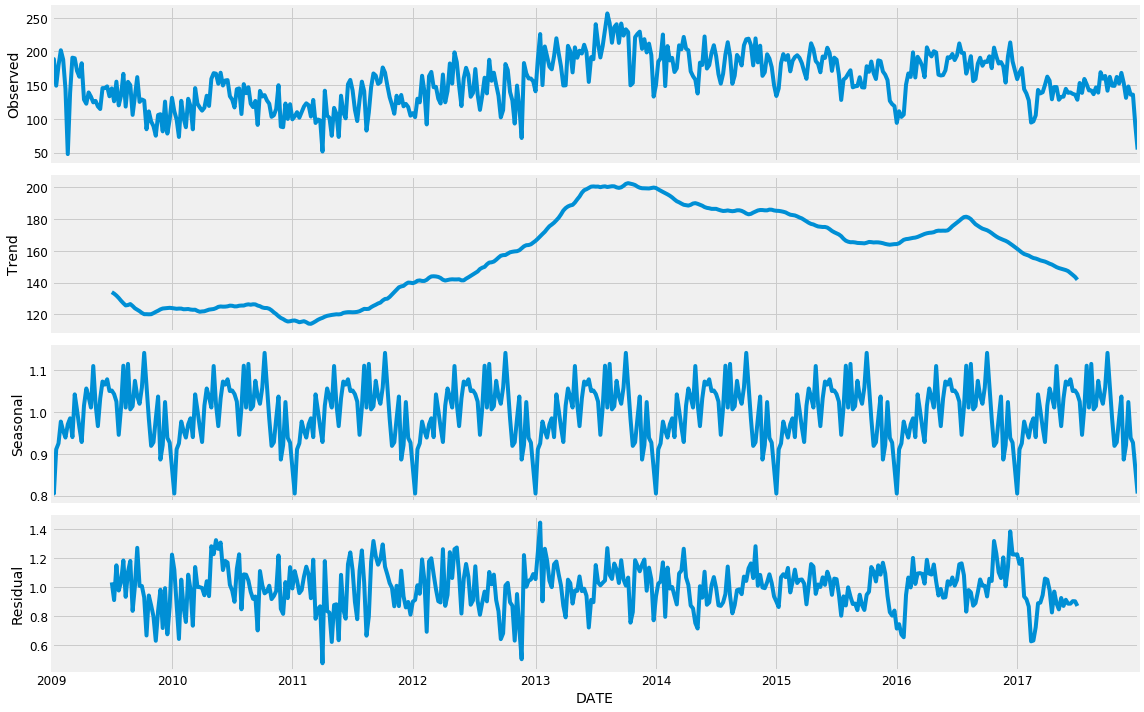

In [29]:
decomposition = sm.tsa.seasonal_decompose(subj, model='multiplicative')
fig = decomposition.plot()
plt.show()

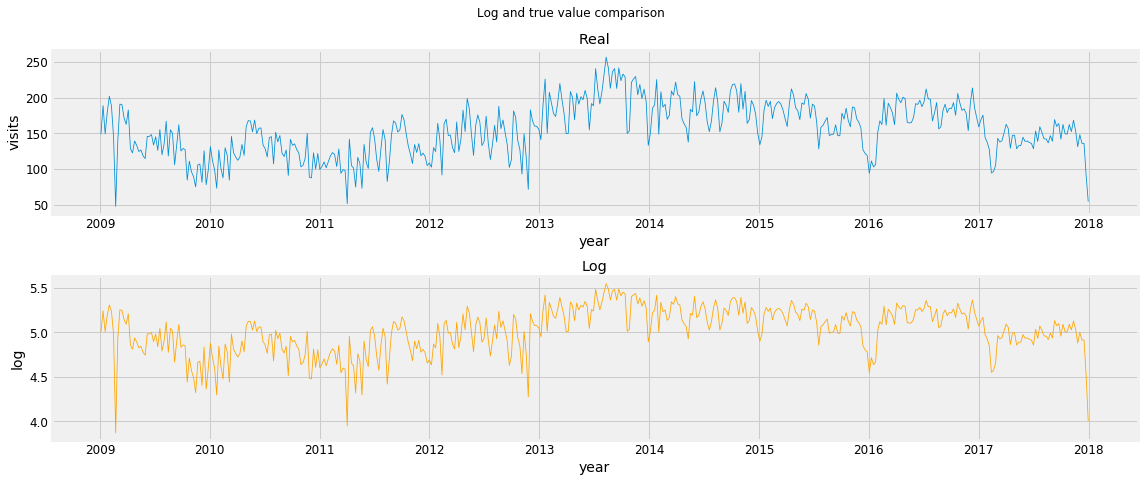

In [30]:
log = np.log(subj)
fig, ax = plt.subplots(2,1,figsize=(16,7))
ax[1].plot(log, linewidth=.8, color="orange")
ax[1].set_title(label="Log")
ax[1].set_xlabel("year")
ax[1].set_ylabel("log")
ax[1].grid(True)

ax[0].set_title(label="Real")
ax[0].plot(subj, linewidth=.8)
ax[0].set_xlabel("year")
ax[0].set_ylabel("visits")


fig.suptitle("Log and true value comparison ")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### MA for smooth data

#### Moving Average
* We take average of ‘k’ consecutive values depending on the frequency of time series.
* Here we can take the average over the past month, i.e. last 28 values (lag of approximately a month).
* A drawback in this particular approach is that the time-period has to be strictly defined.

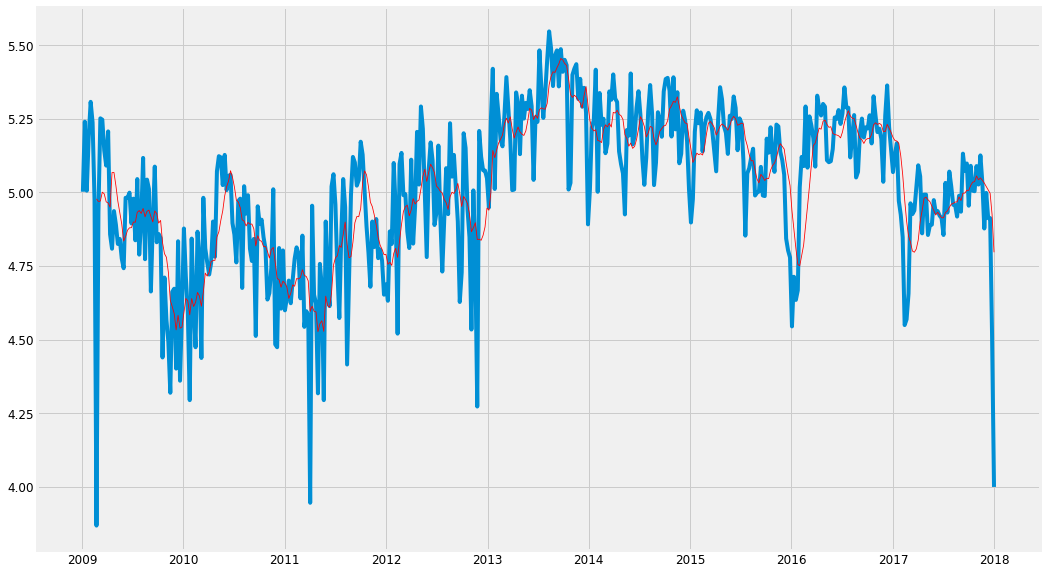

In [31]:
moving_avg = log.rolling(tim_window).mean()
plt.plot(log)
plt.plot(moving_avg, color='red',linewidth=.8)

In [32]:
# log_moving_avg_diff = log_moving_avg_diff.fillna('backfill')

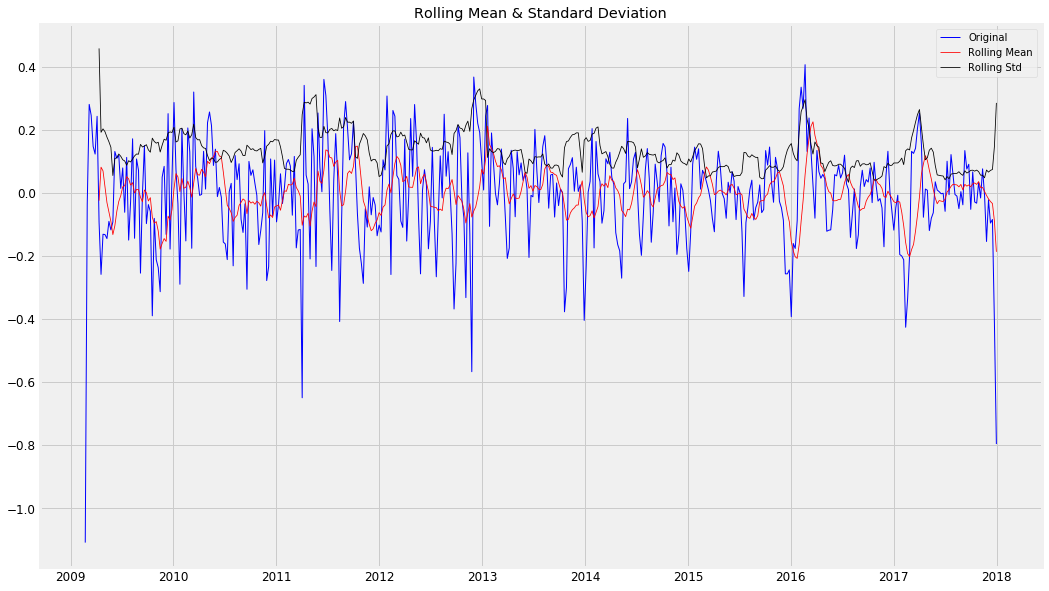

Results of Dickey-Fuller Test:
Test Statistic                -6.976759e+00
p-value                        8.390103e-10
#Lags Used                     1.000000e+01
Number of Observations Used    4.520000e+02
Critical Value (1%)           -3.444900e+00
Critical Value (5%)           -2.867956e+00
Critical Value (10%)          -2.570187e+00
dtype: float64


In [33]:
log_moving_avg_diff = log - moving_avg
moving_avg.isna().sum()
# log_moving_avg_diff[log_moving_avg_diff.VISITS.isna()]
log_moving_avg_diff.dropna(inplace=True)
# log_moving_avg_diff.fillna("ffill")
test_stationarity(log_moving_avg_diff,tim_window)

#### Exponentialy weighted moving average

* To overcome the problem of choosing a defined window in moving average, we can use exponential weighted moving average
* We take a ‘weighted moving average’ where more recent values are given a higher weight.
* There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

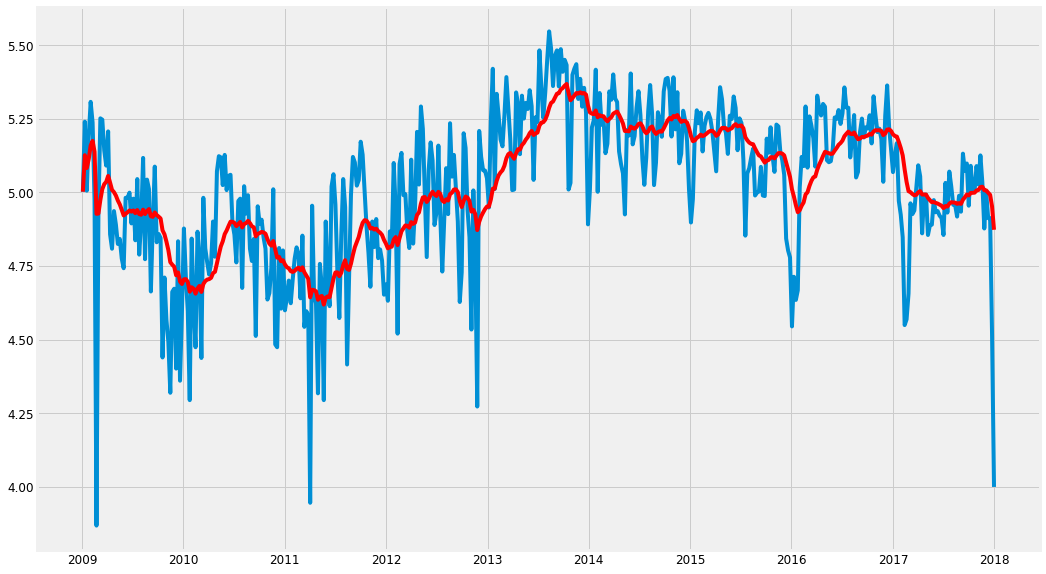

In [34]:
expweighted_avg = pd.Series.ewm(log, halflife=tim_window).mean()
plt.plot(log)
plt.plot(expweighted_avg, color='red')

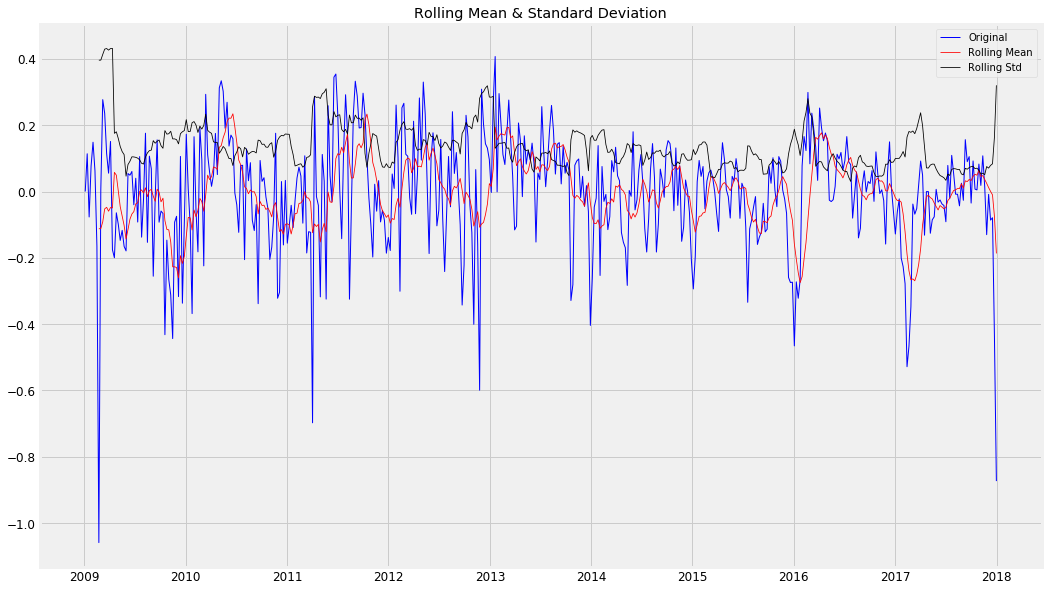

Results of Dickey-Fuller Test:
Test Statistic                  -5.189321
p-value                          0.000009
#Lags Used                       8.000000
Number of Observations Used    461.000000
Critical Value (1%)             -3.444615
Critical Value (5%)             -2.867830
Critical Value (10%)            -2.570120
dtype: float64


In [35]:
log_ewma_diff = log - expweighted_avg
# log_ewma_diff.replace([np.inf, -np.inf], np.nan)
# log_ewma_diff = log_ewma_diff['2009':]
test_stationarity(log_ewma_diff,tim_window)


### Differencing
* In this technique, we take the difference of the observation at a particular instant with that at the previous instant.


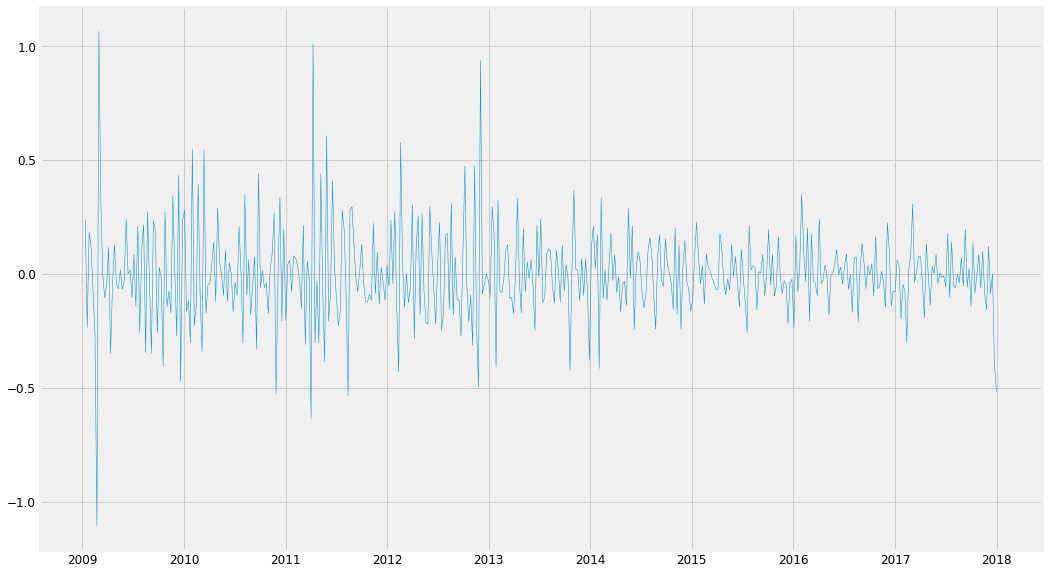

In [36]:
log_diff = log - log.shift()
plt.plot(log_diff,linewidth=.5)

In [37]:
# log_diff = log_diff['2013':]
log_diff.isna().sum()
log_diff.dropna(inplace=True)

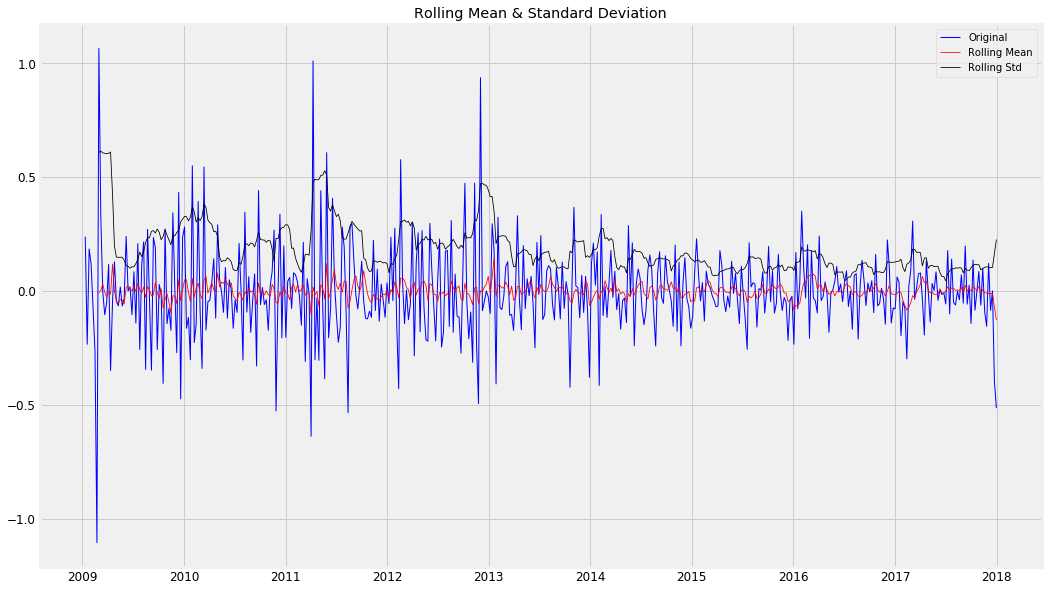

Results of Dickey-Fuller Test:
Test Statistic                -1.093194e+01
p-value                        9.773309e-20
#Lags Used                     7.000000e+00
Number of Observations Used    4.610000e+02
Critical Value (1%)           -3.444615e+00
Critical Value (5%)           -2.867830e+00
Critical Value (10%)          -2.570120e+00
dtype: float64


In [38]:
test_stationarity(log_diff, tim_window)

--------------------
--------------------
--------------------

## Auto Regression (AR)

In [39]:
# fit model
train = log_diff

model = AR(train)
model_fit = model.fit()

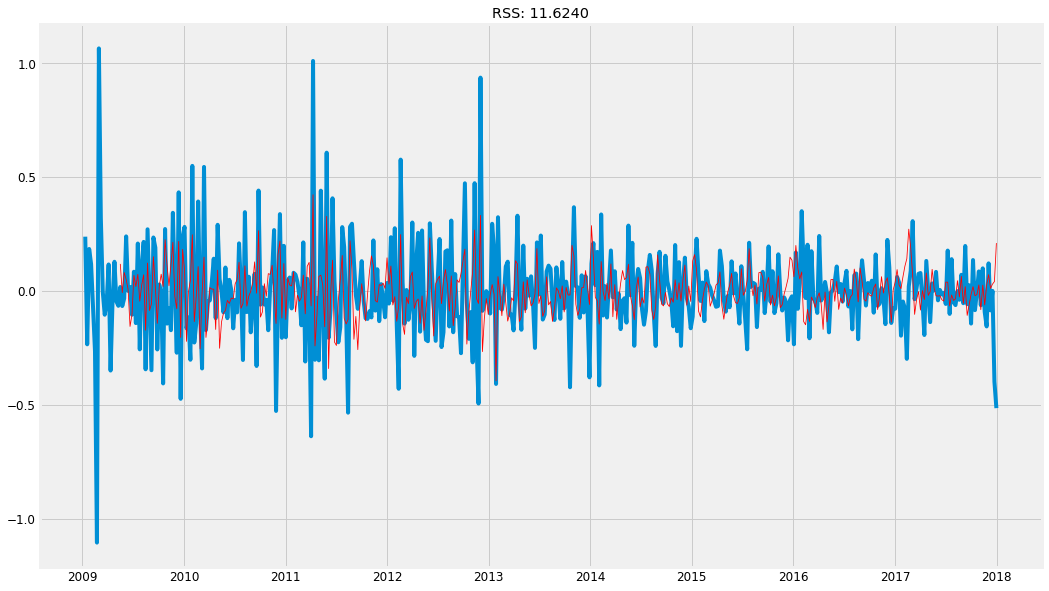

In [40]:
plt.plot(train)
plt.plot(model_fit.fittedvalues, color='red',linewidth=.8)
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-train.VISITS)**2))
plt.show()

### Reversing of transformations

In [41]:
predictions_AR_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_AR_diff.tail(20))

DATE
2017-08-20   -0.026470
2017-08-27    0.063815
2017-09-03   -0.054609
2017-09-10    0.018533
2017-09-17   -0.107498
2017-09-24   -0.060539
2017-10-01   -0.015099
2017-10-08    0.018818
2017-10-15   -0.021326
2017-10-22   -0.015676
2017-10-29    0.026052
2017-11-05   -0.082278
2017-11-12    0.025319
2017-11-19   -0.061283
2017-11-26    0.026224
2017-12-03    0.071357
2017-12-10    0.011196
2017-12-17    0.029697
2017-12-24    0.041092
2017-12-31    0.209913
Freq: W-SUN, dtype: float64


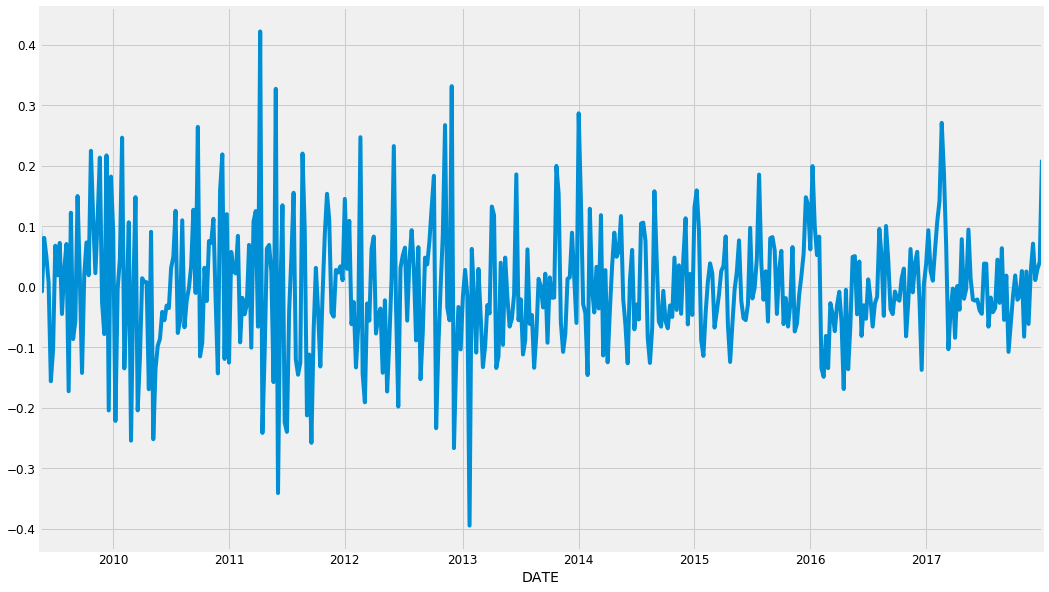

In [42]:
predictions_AR_diff.plot()

In [43]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
print (predictions_AR_diff_cumsum.tail())

DATE
2017-12-03   -1.117268
2017-12-10   -1.106071
2017-12-17   -1.076374
2017-12-24   -1.035282
2017-12-31   -0.825369
Freq: W-SUN, dtype: float64


In [44]:
predictions_AR_log = pd.Series(log.VISITS, index=log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
predictions_AR_log.head()

DATE
2009-01-04    5.002267
2009-01-11    5.240234
2009-01-18    5.005862
2009-01-25    5.189777
2009-02-01    5.307560
Freq: W-SUN, dtype: float64

Text(0.5, 1.0, 'RMSE: 106.7155')

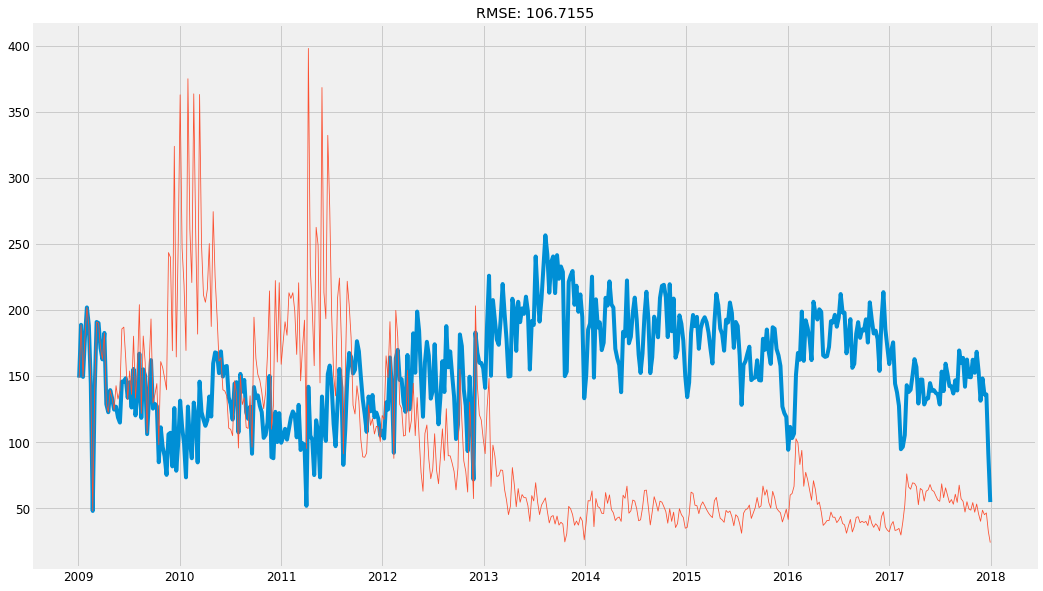

In [45]:
predictions_AR = np.exp(predictions_AR_log)
plt.plot(subj.VISITS)
plt.plot(predictions_AR, linewidth=.8)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_AR-subj.VISITS)**2)/len(subj.VISITS)))

In [46]:
evaluate_forecast(subj.VISITS, predictions_AR)

r2_score  median_absolute_error        mae           mse      msle        rmse       mape
0 -7.206633              97.463475  91.071775  11388.193142  0.966566  106.715478  57.374983

* RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

* From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

* On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations

# Moving Average (ARMA)

In [47]:
# fit model
model = ARMA(log_diff, order=(0,3))
model_fit = model.fit(disp=False)

In [48]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 VISITS   No. Observations:                  469
Model:                     ARMA(0, 3)   Log Likelihood                 149.673
Method:                       css-mle   S.D. of innovations              0.176
Date:                Wed, 27 Nov 2019   AIC                           -289.345
Time:                        22:49:54   BIC                           -268.592
Sample:                    01-11-2009   HQIC                          -281.180
                         - 12-31-2017                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0009      0.002     -0.411      0.681      -0.005       0.003
ma.L1.VISITS    -0.5443      0.047    -11.508      0.000      -0.637      -0.452
ma.L2.VISITS    -0.2341      0.062     -3.795      0.000      -0.355      -0.113
ma.L3.VISITS     0.0441      0.055      0.798      0.425      -0.064       0.152
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.2931           +0.0000j            1.2931            0.0000
MA.2           -2.6367           +0.0000j            2.6367            0.5000
MA.3            6.6536           +0.0000j            6.6536            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 14.5222')

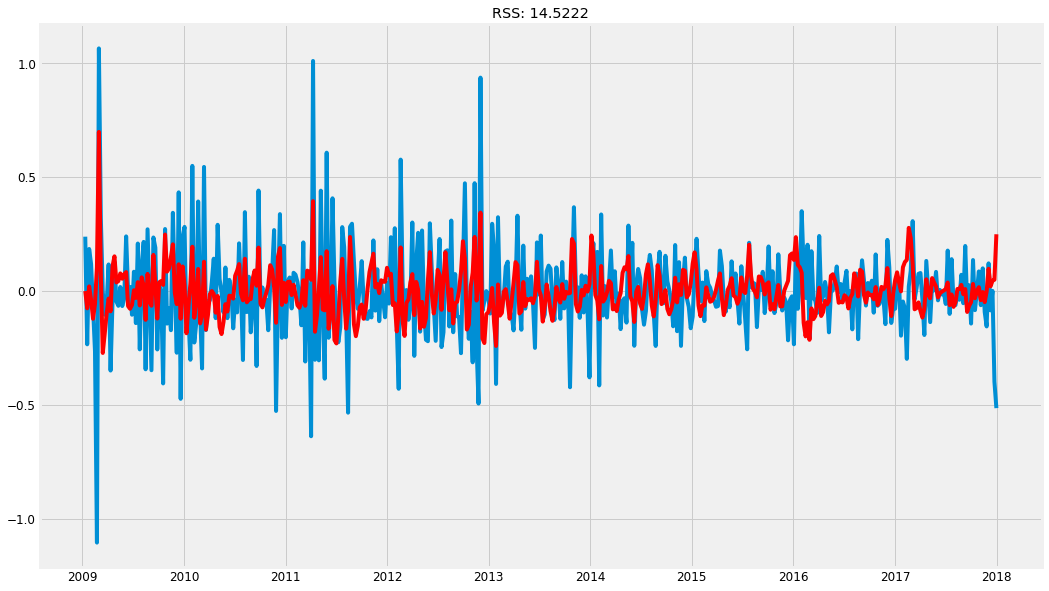

In [49]:
plt.plot(log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-log_diff.VISITS)**2))

In [50]:
# It sucks
evaluate_forecast( subj[1:].VISITS, np.exp(model_fit.fittedvalues))

r2_score  median_absolute_error         mae           mse       msle        rmse      mape
0 -17.229506             154.246681  154.778844  25348.769252  18.826527  159.212968  99.30589

--------------------

# Auto Regressive Integrated Moving Average (ARIMA)

In [51]:
ts = subj.VISITS - subj.VISITS.shift()
ts.dropna(inplace=True)

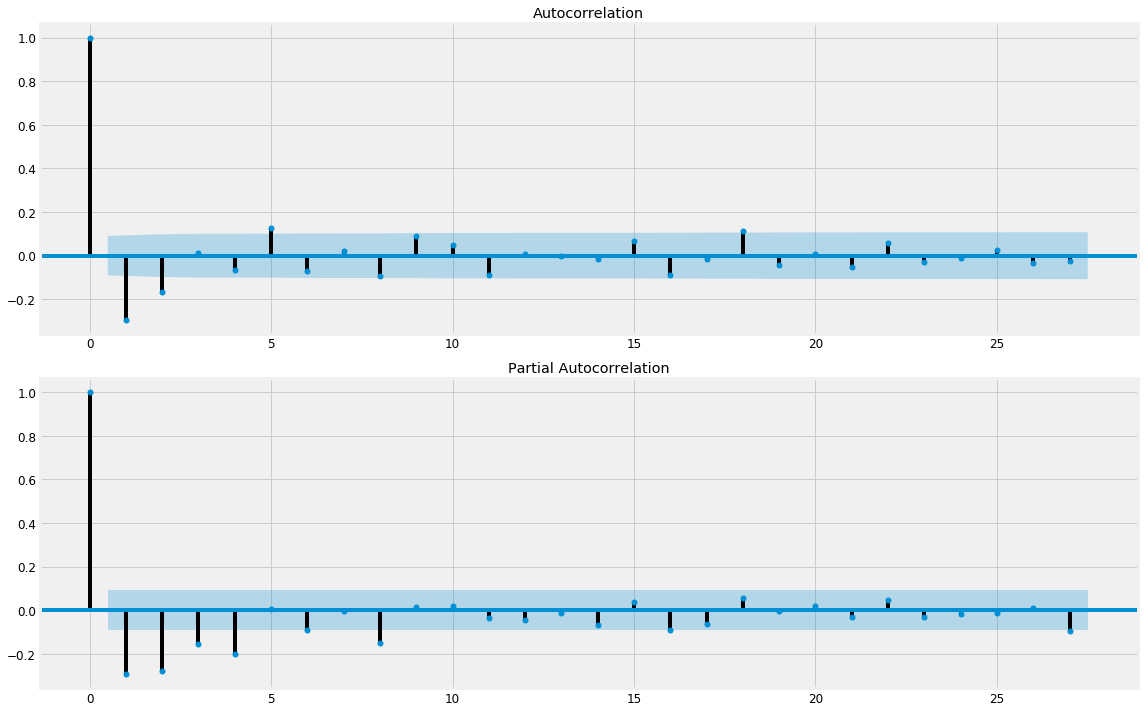

In [52]:
plt.figure()
plt.subplot(211)
plot_acf(ts, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts, ax=plt.gca())
plt.tight_layout()
plt.show()

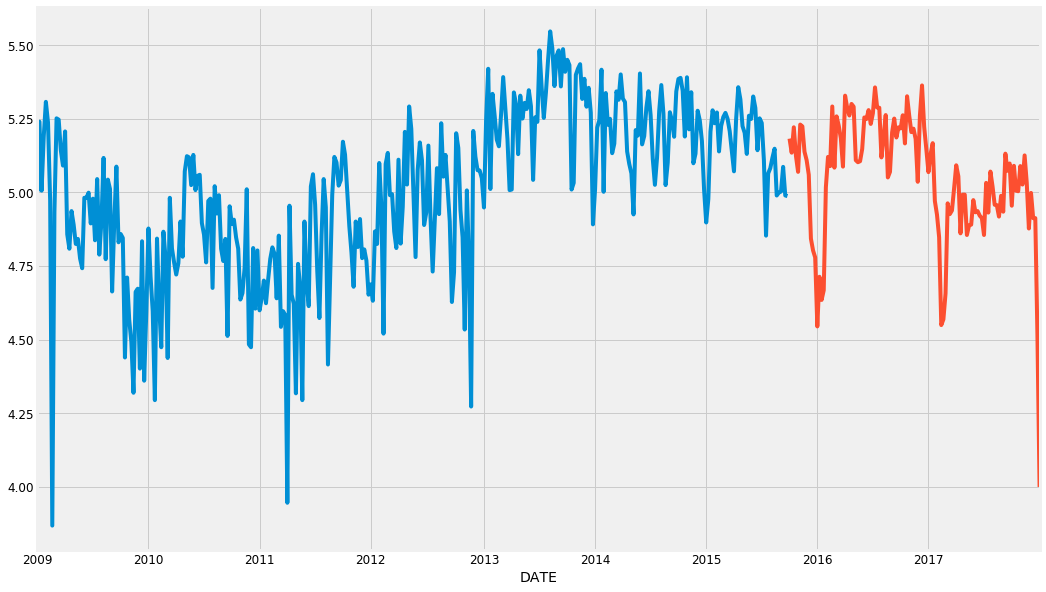

In [53]:
train, test = subj[:int(0.75*len(subj))], subj[int(0.75*len(subj)):]

# plot the values of smooth data
np.log(train['VISITS']).plot()
np.log(test['VISITS']).plot()

# plot the original values of the data
# train['VISITS'].plot()
# test['VISITS'].plot()

In [54]:
# 
model = ARIMA(train,order=(5, 1,3))
model_fit = model.fit(disp=1)

In [55]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.VISITS   No. Observations:                  351
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -1611.786
Method:                       css-mle   S.D. of innovations             23.837
Date:                Wed, 27 Nov 2019   AIC                           3243.572
Time:                        22:50:05   BIC                           3282.180
Sample:                    01-11-2009   HQIC                          3258.937
                         - 09-27-2015                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0303      0.326     -0.093      0.926      -0.669       0.609
ar.L1.D.VISITS    -1.7002      0.100    -16.949      0.000      -1.897      -1.504
ar.L2.D.VISITS    -0.7238      0.212     -3.411      0.001      -1.140      -0.308
ar.L3.D.VISITS    -0.1697      0.221     -0.769      0.443      -0.602       0.263
ar.L4.D.VISITS    -0.2873      0.163     -1.766      0.078      -0.606       0.032
ar.L5.D.VISITS    -0.1271      0.072     -1.762      0.079      -0.269       0.014
ma.L1.D.VISITS     1.1684      0.091     12.837      0.000       0.990       1.347
ma.L2.D.VISITS    -0.4833      0.158     -3.058      0.002      -0.793      -0.174
ma.L3.D.VISITS    -0.6676      0.091     -7.324      0.000      -0.846      -0.489
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9069           -1.5557j            1.8007           -0.1660
AR.2            0.9069           +1.5557j            1.8007            0.1660
AR.3           -1.0692           -0.0000j            1.0692           -0.5000
AR.4           -1.5023           -0.1096j            1.5063           -0.4884
AR.5           -1.5023           +0.1096j            1.5063            0.4884
MA.1            1.3641           -0.0000j            1.3641           -0.0000
MA.2           -1.0440           -0.0901j            1.0479           -0.4863
MA.3           -1.0440           +0.0901j            1.0479            0.4863
-----------------------------------------------------------------------------
"""

In [56]:
start_index = test.index.min()
end_index = test.index.max()
#make predictions with model
predictions = model_fit.predict(start=start_index, end=end_index)

In [57]:
mse = mean_squared_error(subj[start_index:end_index], predictions)
rmse = sqrt(mse)
#
print('RMSE: {}, MSE: {}'.format(rmse,mse))


RMSE: 161.78059321117368, MSE: 26172.960339759255


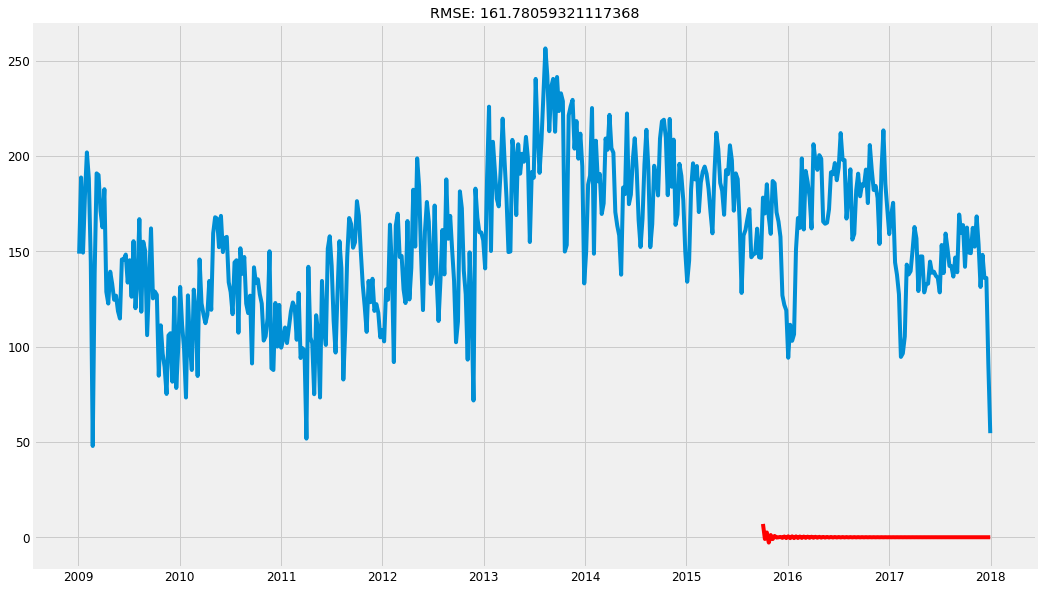

In [58]:
plt.plot(subj.VISITS)
plt.plot(predictions, color='red')
plt.title('RMSE: {}'.format(rmse))
plt.show()

#### Fitted or predicted values

In [59]:
predictions_ARIMA_diff = pd.Series(predictions,copy=True)
predictions_ARIMA_diff.head(5)

2015-10-04    6.940937
2015-10-11   -0.954108
2015-10-18    2.481163
2015-10-25   -2.838015
2015-11-01    1.112015
Freq: W-SUN, dtype: float64

#### Cumulative sum to reverse differencing

In [60]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head(5)

2015-10-04    6.940937
2015-10-11    5.986830
2015-10-18    8.467993
2015-10-25    5.629978
2015-11-01    6.741992
Freq: W-SUN, dtype: float64

#### Add 1rst day value which was removed

In [61]:
predictions_ARIMA_log = pd.Series(test.VISITS.iloc[0], index=test.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

DATE
2015-10-04    185.083794
2015-10-11    184.129687
2015-10-18    186.610850
2015-10-25    183.772835
2015-11-01    184.884849
Freq: W-SUN, dtype: float64

#### Exponent to reverse log

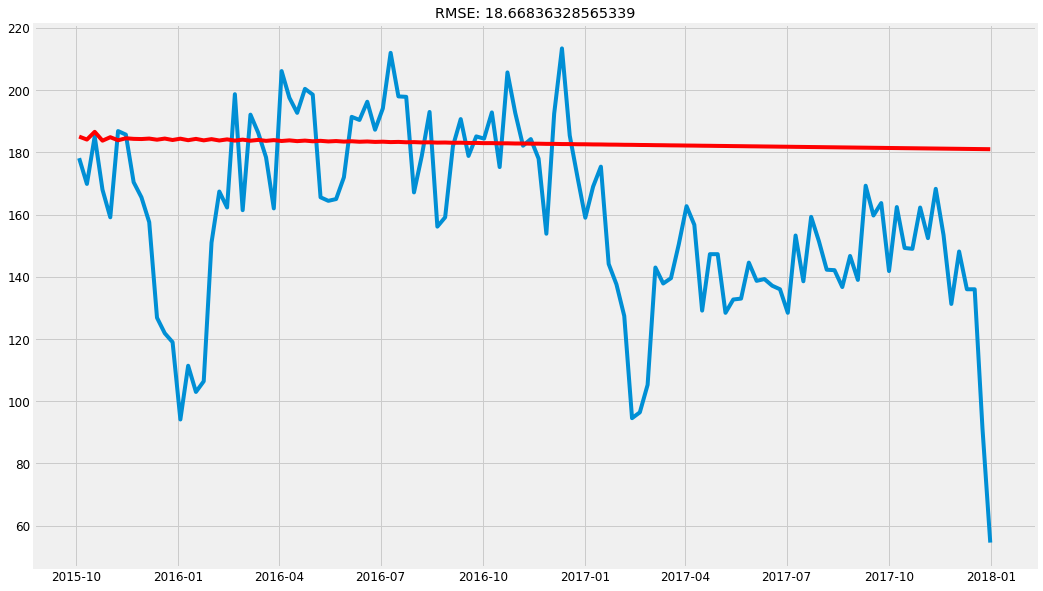

In [62]:
plt.plot(subj.VISITS[int(len(subj)*.75):])
plt.plot(predictions_ARIMA_log, color="red")
plt.title('RMSE: {}'.format(np.sqrt(np.nansum((predictions_ARIMA_log-subj[start_index:end_index].VISITS)**2)/len(ts))))
plt.show()

In [63]:
predictions_ARIMA_log

DATE
2015-10-04    185.083794
2015-10-11    184.129687
2015-10-18    186.610850
2015-10-25    183.772835
2015-11-01    184.884849
                 ...    
2017-12-03    181.149373
2017-12-10    181.118376
2017-12-17    181.088721
2017-12-24    181.057811
2017-12-31    181.028074
Freq: W-SUN, Length: 118, dtype: float64

In [64]:
evaluate_forecast(subj[start_index:end_index].VISITS, predictions_ARIMA_log)

r2_score  median_absolute_error       mae          mse      msle       rmse       mape
0 -0.634048              22.732286  28.98227  1385.170784  0.066389  37.217883  22.636438

# AUTO ARIMA

In [65]:
model = auto_arima(train,trace=True, error_action="ignore", supress_warnings=True)
model.fit(train)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=3242.642, BIC=3265.806, Fit time=0.362 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=3355.038, BIC=3362.759, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=3322.034, BIC=3333.616, Fit time=0.117 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=3261.310, BIC=3272.892, Fit time=0.079 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=3243.029, BIC=3262.333, Fit time=0.281 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=3244.578, BIC=3271.603, Fit time=0.432 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=3247.431, BIC=3266.735, Fit time=0.190 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=3244.621, BIC=3271.647, Fit time=0.486 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=3248.814, BIC=3264.257, Fit time=0.154 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args=None,
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

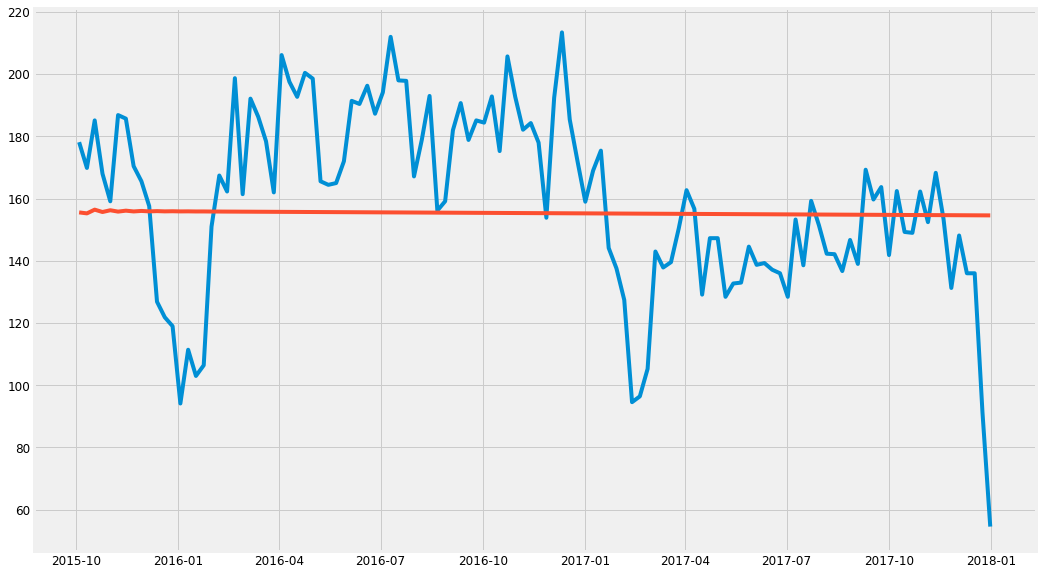

In [66]:
forecast = model.predict(n_periods= len(test))
forecast = pd.DataFrame(forecast, index= test.index,columns=["Prediction"])

#plot the forecast
plt.plot(subj.VISITS[int(len(subj)*.75):], label="Train")
plt.plot(forecast, label="Prediction")
plt.show()

In [67]:
evaluate_forecast(test.VISITS, forecast.Prediction)

r2_score  median_absolute_error        mae         mse      msle       rmse       mape
0 -0.007041              18.796451  23.421441  853.661286  0.042185  29.217483  16.459913

# SARIMA

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Trend Elements:

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

p: Trend autoregression order.
d: Trend difference order.
q: Trend moving average order.
Seasonal Elements:

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.
D: Seasonal difference order.
Q: Seasonal moving average order.
m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

SARIMA notation: SARIMA(p,d,q)(P,D,Q,m)

In [68]:
# fit model
model = SARIMAX(train, order=(3, 1, 3), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

In [69]:
start_index = test.index.min()
end_index = test.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [70]:
# report performance
mse = mean_squared_error(subj[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 29.359521537586694, MSE:861.9815049160169


Text(0.5, 1.0, 'RMSE: 29.3595')

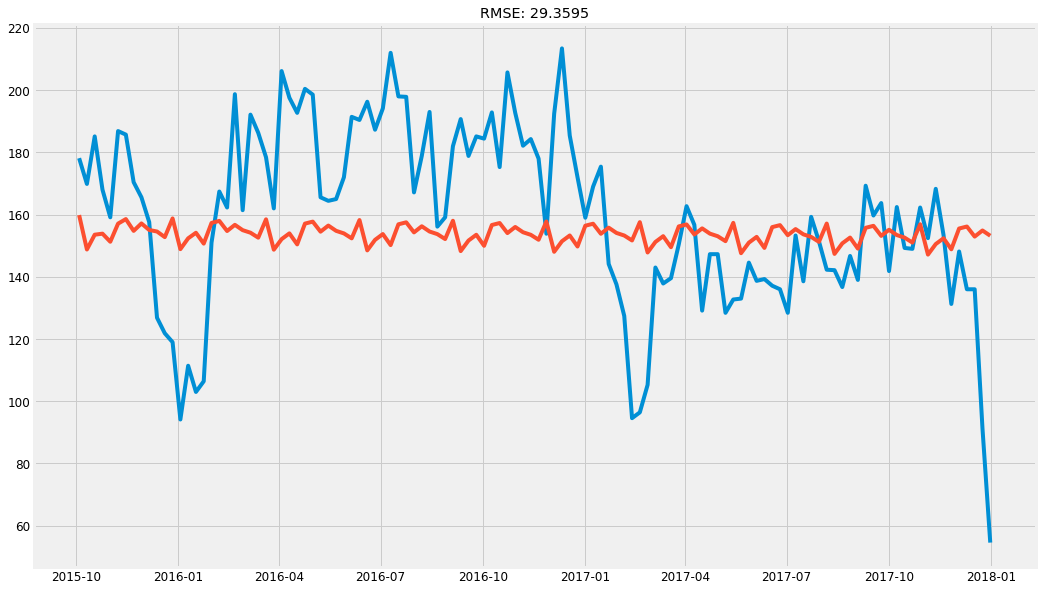

In [71]:
plt.plot(subj[int(len(subj)*.75):])
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [72]:
evaluate_forecast(subj[start_index:end_index].VISITS, predictions)

r2_score  median_absolute_error        mae         mse      msle       rmse       mape
0 -0.016856              18.566576  23.428474  861.981505  0.042038  29.359522  16.264454

# Auto SARIMA


In [87]:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=52, stepwise=True)
model.fit(train)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 52); AIC=3246.541, BIC=3277.427, Fit time=23.518 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 52); AIC=3355.038, BIC=3362.759, Fit time=0.017 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 52); AIC=3323.839, BIC=3339.282, Fit time=6.768 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 52); AIC=3263.246, BIC=3278.689, Fit time=3.597 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 52); AIC=3244.622, BIC=3271.647, Fit time=11.575 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 52); AIC=3242.642, BIC=3265.806, Fit time=0.294 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 52); AIC=3243.029, BIC=3262.333, Fit time=0.280 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 52); AIC=3244.578, BIC=3271.603, Fit time=0.397 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 52); AIC=3247.431, BIC=3266.735, Fit time=0.181 seconds
Fit ARIMA: order=(2, 1, 3)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args=None,
      seasonal_order=(0, 0, 0, 52), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

In [74]:
# report performance
mse = mean_squared_error(subj[start_index:end_index], forecast)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 29.21748254048649, MSE:853.6612860036328


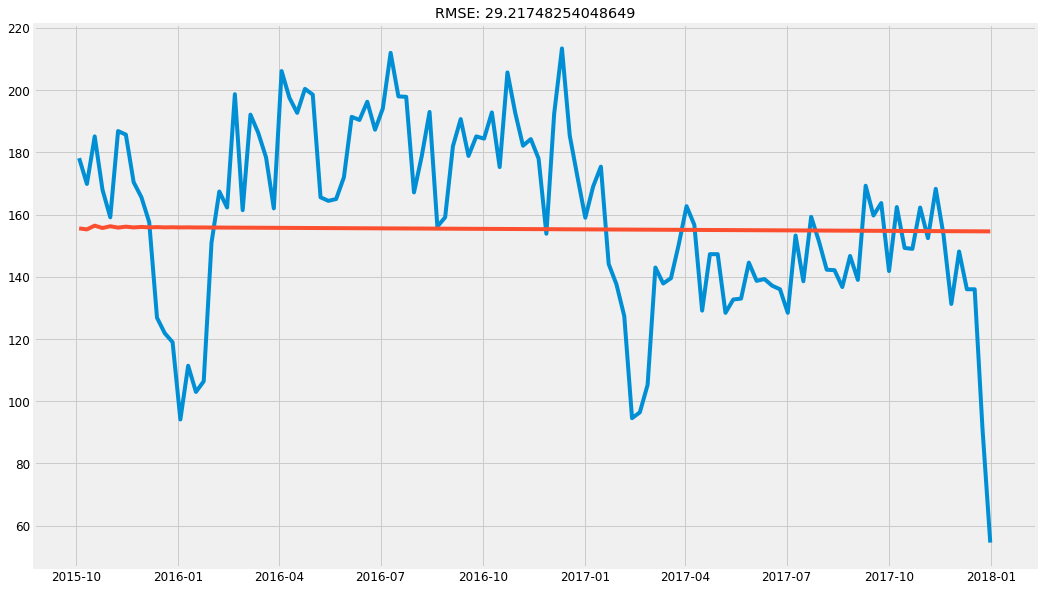

In [75]:
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(subj.VISITS[int(len(subj)*.75):], label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.title("RMSE: {}".format(rmse))
plt.show()

In [76]:
evaluate_forecast(subj[start_index:end_index].VISITS, forecast.Prediction)

r2_score  median_absolute_error        mae         mse      msle       rmse       mape
0 -0.007041              18.796451  23.421441  853.661286  0.042185  29.217483  16.459913

# Prophet

Prophet is open source software released by Facebook's Core Data Science team.
Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
It works best with time series that have strong seasonal effects and several seasons of historical data.
Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
The Prophet package provides intuitive parameters which are easy to tune.
Prophet example notebooks

Trend parameters

growth: 'linear' or 'logistic' to specify a linear or logistic trend
changepoints: List of dates at which to include potential changepoints (automatic if not specified)
n_changepoints: If changepoints in not supplied, you may provide the number of changepoints to be automatically included
changepoint_prior_scale: Parameter for changing flexibility of automatic changepoint selection
Seasonality and Holiday Parameters

yearly_seasonality: Fit yearly seasonality
weekly_seasonality: Fit weekly seasonality
daily_seasonality: Fit daily seasonality
holidays: Feed dataframe containing holiday name and date
seasonality_prior_scale: Parameter for changing strength of seasonality model
holiday_prior_scale: Parameter for changing strength of holiday model
Prophet requires the variable names in the time series to be:

* y – Target
* ds – Datetime

In [88]:
# weekly frequency
subj_p = subj
fr = 'W'

# daily frequency
# subj_p = ts_MCSSA010280['2009':]
# fr = 'D'

#divide set into train and test sets
train_p, test_p = subj_p[:int(0.75*len(subj_p))], subj_p[int(0.75*len(subj_p)):]

In [89]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train_p.index
train_prophet['y'] = train_p.VISITS.values
train_prophet.head()

ds           y
0 2009-01-04  148.750000
1 2009-01-11  188.714286
2 2009-01-18  149.285714
3 2009-01-25  179.428571
4 2009-02-01  201.857143

In [90]:
# daily frequency of data
# model = Prophet( weekly_seasonality=True, seasonality_mode = 'multiplicative')

#instantiate Prophet with only weekly seasonality as our data is daily 
model = Prophet( seasonality_mode = 'multiplicative')
# in case frequency is weekly
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train_prophet) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [91]:
# Create a new dataframe with peridos to predict
future = model.make_future_dataframe(periods = len(test_p), freq = fr) 
future.tail()

ds
465 2017-12-03
466 2017-12-10
467 2017-12-17
468 2017-12-24
469 2017-12-31

In [92]:
forecast_prophet = model.predict(future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds        yhat  yhat_lower  yhat_upper
0 2009-01-04  118.995954   84.453157  151.958811
1 2009-01-11  125.511737   92.269015  156.846867
2 2009-01-18  136.787653  106.404338  170.247231
3 2009-01-25  145.047529  115.708038  175.191189
4 2009-02-01  149.565955  114.563569  180.872370

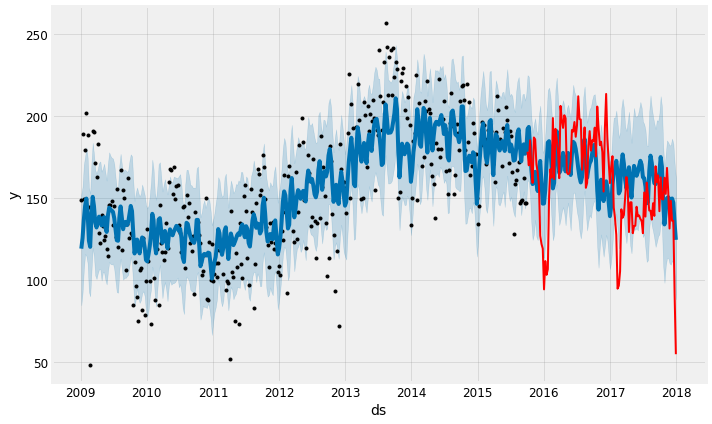

In [93]:
fig = model.plot(forecast_prophet)
#plot the predictions for validation set
# forecast.plot()
plt.plot(test_p, label='Valid', color = 'red', linewidth = 2)

plt.show()

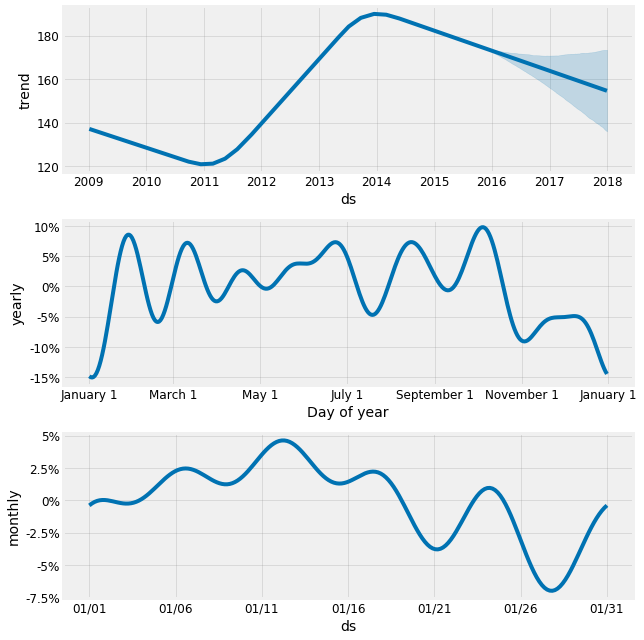

In [94]:
model.plot_components(forecast_prophet);

In [95]:
subj_prophet = pd.DataFrame()
subj_prophet['ds'] = subj_p.index
subj_prophet['y'] = subj_p.VISITS.values

In [96]:
subj_prophet = subj_prophet.set_index('ds')
forecast_prophett = forecast_prophet.set_index('ds')

In [97]:
evaluate_forecast(subj_prophet.y[start_index:end_index][:len(test_p)], forecast_prophett.yhat[start_index:end_index])


r2_score  median_absolute_error        mae         mse      msle       rmse       mape
0  0.076469               19.23949  22.153796  782.870792  0.038759  27.979828  16.090374

-------
-------

# LSTM

### Baseline Predictions
* ##### Persistence model (Naive forecast)

In [98]:
X = subj['2011':'2015']
X

VISITS
DATE                  
2011-01-02   99.428571
2011-01-09  103.714286
2011-01-16  110.000000
2011-01-23  101.857143
2011-01-30  110.285714
...                ...
2015-11-29  165.571429
2015-12-06  157.571429
2015-12-13  126.857143
2015-12-20  121.857143
2015-12-27  119.000000

[261 rows x 1 columns]

In [99]:
lstm_train, lstm_test = X[:int(len(X)*.75)], X[int(len(X)*.75):]
display(len(lstm_train), len(lstm_test))

195

66

In [100]:
# walk-forward validation
history = [x for x in lstm_train.VISITS]
lstm_predictions = list()
for i in range(len(lstm_test)):
    # make prediction
    lstm_predictions.append(history[-1])
    # observation
    history.append(lstm_test.VISITS[i])

# report performance
rmse = sqrt(mean_squared_error(lstm_test.VISITS, lstm_predictions))
evaluate_forecast(lstm_test.VISITS, lstm_predictions)

r2_score  median_absolute_error        mae         mse      msle       rmse      mape
0  0.351695              12.714286  15.272727  363.105751  0.012011  19.055334  8.833513

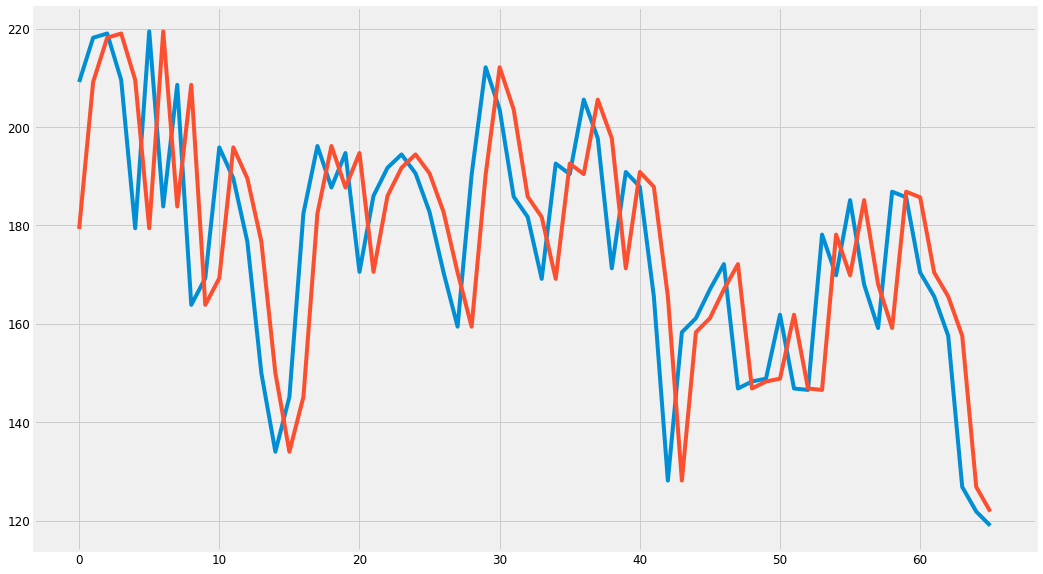

In [101]:
# line plot of observed vs predicted
plt.plot(lstm_test.VISITS.values)
plt.plot(lstm_predictions)
plt.show()

### Data Preparation
* #### Transform into supervised learning

In [102]:
# Function to transform to supervised learning
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [103]:
# transform to supervised learning
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

                VISITS      VISITS
DATE                              
2011-01-02    0.000000   99.428571
2011-01-09   99.428571  103.714286
2011-01-16  103.714286  110.000000
2011-01-23  110.000000  101.857143
2011-01-30  101.857143  110.285714


In [104]:
# difference value
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [105]:
X

VISITS
DATE                  
2011-01-02   99.428571
2011-01-09  103.714286
2011-01-16  110.000000
2011-01-23  101.857143
2011-01-30  110.285714
...                ...
2015-11-29  165.571429
2015-12-06  157.571429
2015-12-13  126.857143
2015-12-20  121.857143
2015-12-27  119.000000

[261 rows x 1 columns]

* #### Enssure stationarity

In [106]:
differenced = difference(X.VISITS, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
    value = inverse_difference(X.VISITS, differenced[i], len(X.VISITS)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

0    4.285714
1    6.285714
2   -8.142857
3    8.428571
4    8.142857
dtype: float64
0    103.714286
1    110.000000
2    101.857143
3    110.285714
4    118.428571
dtype: float64


* #### Scale TS (Min-Max)

In [107]:
# scalee transform from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = pd.Series(scaled_X[:, 0])

In [108]:
# invert transform 
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = pd.Series(inverted_X[:, 0])
display(scaled_series.head())
display(inverted_series.head())

0   -0.533845
1   -0.491975
2   -0.430565
3   -0.510119
4   -0.427774
dtype: float64

0     99.428571
1    103.714286
2    110.000000
3    101.857143
4    110.285714
dtype: float64

-----
### LSTM Model development

The Long Short-Term Memory network (LSTM) is a type of Recurrent Neural Network (RNN).

A benefit of this type of network is that it can learn and remember over long sequences and does not rely on a pre-specified window lagged observation as input.

In Keras, this is referred to as stateful, and involves setting the “stateful” argument to “True” when defining an LSTM layer.

By default, an LSTM layer in Keras maintains state between data within one batch. A batch of data is a fixed-sized number of rows from the training dataset that defines how many patterns to process before updating the weights of the network. State in the LSTM layer between batches is cleared by default, therefore we must make the LSTM stateful. This gives us fine-grained control over when state of the LSTM layer is cleared, by calling the reset_states() function.

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].

* Samples: These are independent observations from the domain, typically rows of data.
* Time steps: These are separate time steps of a given variable for a given observation.
* Features: These are separate measures observed at the time of observation.

We have some flexibility in how the ED visits dataset is framed for the network. We will keep it simple and frame the problem as each time step in the original sequence is one separate sample, with one timestep and one feature.

Given that the training dataset is defined as X inputs and y outputs, it must be reshaped into the Samples/TimeSteps/Features format, for example:

```python
X, y = train[:, 0:-1], train[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
```

The shape of the input data must be specified in the LSTM layer using the “batch_input_shape” argument as a tuple that specifies the expected number of observations to read each batch, the number of time steps, and the number of features.

The batch size is often much smaller than the total number of samples. It, along with the number of epochs, defines how quickly the network learns the data (how often the weights are updated).

The final import parameter in defining the LSTM layer is the number of neurons, also called the number of memory units or blocks. This is a reasonably simple problem and a number between 1 and 5 should be sufficient.

The line below creates a single LSTM hidden layer that also specifies the expectations of the input layer via the “batch_input_shape” argument.

```python
layer = LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)
```

The network requires a single neuron in the output layer with a linear activation to predict the number of ED visits at the next time step.

Once the network is specified, it must be compiled into an efficient symbolic representation using a backend mathematical library, such as TensorFlow or Theano.

In compiling the network, we must specify a loss function and optimization algorithm. We will use “mean_squared_error” as the loss function as it closely matches RMSE that we will are interested in, and the efficient ADAM optimization algorithm.

Using the Sequential Keras API to define the network, the below snippet creates and compiles the network.

```python
model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
```

Once compiled, it can be fit to the training data. Because the network is stateful, we must control when the internal state is reset. Therefore, we must manually manage the training process one epoch at a time across the desired number of epochs.

By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations. We can disable the shuffling of samples by setting “shuffle” to “False“.

Also by default, the network reports a lot of debug information about the learning progress and skill of the model at the end of each epoch. We can disable this by setting the “verbose” argument to the level of “0“.

We can then reset the internal state at the end of the training epoch, ready for the next training iteration.

Below is a loop that manually fits the network to the training data.

```python
for i in range(nb_epoch):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	model.reset_states()
```

Putting this all together, we can define a function called fit_lstm() that trains and returns an LSTM model. As arguments, it takes the training dataset in a supervised learning format, a batch size, a number of epochs, and a number of neurons.

```python
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
```

The batch_size must be set to 1. This is because it must be a factor of the size of the training and test datasets.

The predict() function on the model is also constrained by the batch size; there it must be set to 1 because we are interested in making one-step forecasts on the test data.

We will not tune the network parameters in this tutorial; instead we will use the following configuration, found with a little trial and error:

* Batch Size: 1
* Epochs: 3000
* Neurons: 4

As an extension to this tutorial, you might like to explore different model parameters and see if you can improve performance.

* Update: Consider trying 1500 epochs and 1 neuron, the performance may be better!

Next, we will look at how we can use a fit LSTM model to make a one-step forecast.

### LSTM Forecast

Once the LSTM model is fit to the training data, it can be used to make forecasts.

Again, we have some flexibility. We can decide to fit the model once on all of the training data, then predict each new time step one at a time from the test data (we’ll call this the fixed approach), or we can re-fit the model or update the model each time step of the test data as new observations from the test data are made available (we’ll call this the dynamic approach).

In this tutorial, we will go with the fixed approach for its simplicity, although, we would expect the dynamic approach to result in better model skill.

To make a forecast, we can call the predict() function on the model. This requires a 3D NumPy array input as an argument. In this case, it will be an array of one value, the observation at the previous time step.

The predict() function returns an array of predictions, one for each input row provided. Because we are providing a single input, the output will be a 2D NumPy array with one value.

We can capture this behavior in a function named forecast() listed below. Given a fit model, a batch-size used when fitting the model (e.g. 1), and a row from the test data, the function will separate out the input data from the test row, reshape it, and return the prediction as a single floating point value.

```python
def forecast(model, batch_size, row):
	X = row[0:-1]
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
```

During training, the internal state is reset after each epoch. While forecasting, we will not want to reset the internal state between forecasts. In fact, we would like the model to build up state as we forecast each time step in the test dataset.

This raises the question as to what would be a good initial state for the network prior to forecasting the test dataset.

In this tutorial, we will seed the state by making a prediction on all samples in the training dataset. In theory, the internal state should be set up ready to forecast the next time step.

We now have all of the pieces to fit an LSTM Network model for the ED visits dataset and evaluate its performance.

In the next section, we will put all of these pieces together.

### All of LSTM together

In this section, we will fit an LSTM to the ED visits dataset and evaluate the model.

This will involve drawing together all of the elements from the prior sections. There are a lot of them, so let’s review:

1. Load the dataset from CSV file.
2. Transform the dataset to make it suitable for the LSTM model, including:
3. Transforming the data to a supervised learning problem.
4. Transforming the data to be stationary.
5. Transforming the data so that it has the scale -1 to 1.
6. Fitting a stateful LSTM network model to the training data.
7. Evaluating the static LSTM model on the test data.
8. Report the performance of the forecasts.

Some things to note about the example:

* The scaling and inverse scaling behaviors have been moved to the functions scale() and invert_scale() for brevity.
* The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max values of the test data do not influence the model.
* The order of data transforms was adjusted for convenience to first make the data stationary, then a supervised learning problem, then scaled.
* Differencing was performed on the entire dataset prior to splitting into train and test sets for convenience. We could just as easily collect observations during the walk-forward validation and difference them as we go. I decided against it for readability.

The complete example is listed below.

In [109]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [110]:
# load dataset
series = subj['2011':'2014']
# define split (train/test)
split = int(len(series)*.75)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[:split], supervised_values[split:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [111]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 2000, 3)

In [112]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.12829274],
       [-0.27892655],
       [-0.24313177],
       [-0.25561488],
       [-0.13207255],
       [-0.25137845],
       [-0.20619185],
       [-0.22237672],
       [-0.1889985 ],
       [-0.13288595],
       [ 0.08514904],
       [-0.00523819],
       [-0.2452807 ],
       [ 0.19234958],
       [-0.36129373],
       [-0.23699908],
       [-0.23308192],
       [-0.06213262],
       [-0.26053268],
       [-0.35482505],
       [ 0.11785121],
       [-0.41904217],
       [-0.4406384 ],
       [-0.2512055 ],
       [-0.22751667],
       [-0.50000685],
       [-0.19640742],
       [-0.08232196],
       [-0.0223276 ],
       [-0.17164932],
       [-0.35256684],
       [-0.279995  ],
       [ 0.33392483],
       [ 0.17936899],
       [-0.1556753 ],
       [-0.34194815],
       [-0.2782322 ],
       [-0.23470907],
       [-0.12169349],
       [-0.22243012],
       [-0.2801842 ],
       [-0.18137676],
       [-0.09915948],
       [-0.01981396],
       [ 0.00224852],
       [-0

In [113]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Value=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Value=1, Predicted=169.480706, Expected=150.000000
Value=2, Predicted=195.095964, Expected=185.000000
Value=3, Predicted=194.841954, Expected=189.714286
Value=4, Predicted=174.429691, Expected=225.142857
Value=5, Predicted=247.832140, Expected=148.714286
Value=6, Predicted=158.911742, Expected=208.000000
Value=7, Predicted=189.253009, Expected=186.714286
Value=8, Predicted=228.855027, Expected=190.571429
Value=9, Predicted=219.939980, Expected=169.571429
Value=10, Predicted=172.900142, Expected=175.142857
Value=11, Predicted=179.604592, Expected=209.142857
Value=12, Predicted=197.302343, Expected=203.285714
Value=13, Predicted=182.389951, Expected=221.571429
Value=14, Predicted=220.160511, Expected=204.142857
Value=15, Predicted=194.225503, Expected=201.714286
Value=16, Predicted=202.444707, Expected=170.571429
Value=17, Predicted=177.466973, Expected=163.428571
Value=18, Predicted=188.395737, Expected=158.285714
Value=19, Predicted=179.161575, Expected=137.714286
Value=20, Predicted=1

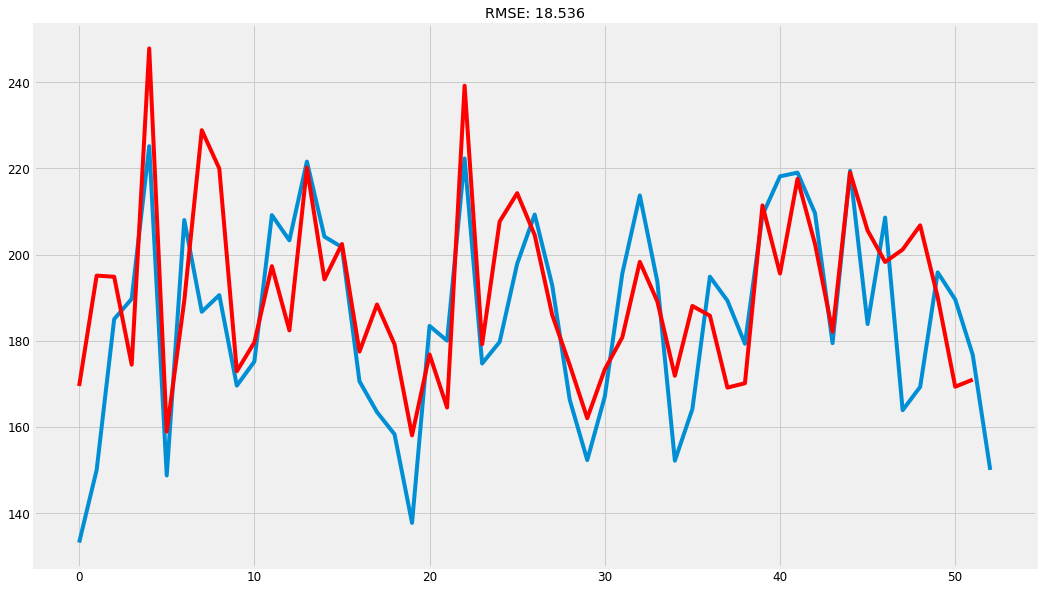

In [114]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[split:len(raw_values)-1], predictions))

# line plot of observed vs predicted
plt.plot(raw_values[split:])
plt.plot(predictions, color="red")
plt.title('RMSE: %.3f' % rmse)
plt.show()

In [115]:
evaluate_forecast(raw_values[split:len(raw_values)-1],predictions)

r2_score  median_absolute_error        mae         mse      msle       rmse      mape
0  0.341119              11.071784  14.822339  343.566192  0.010214  18.535539  8.386196

-------------------
-------
### TODO =  CNN / CONVLSTM\  CNN LSTM

## Pendiente

In [ ]:
b = sns.boxplot(data=ts_hospitals[2:], palette="Blues")
b = sns.stripplot(data=ts_hospitals[2:], color="orange", jitter=0.2, size=2.5)
b.set_xticklabels(hospitals[2:], rotation=-90)
plt.tight_layout()
display(ts_GTSSA002101.quantile(.25))
display(stats.zscore(ts_GTSSA002101))
display(ts_GTSSA002101.shape)
## z score outlier detection
ind = ts_GTSSA002101[(np.abs(stats.zscore(ts_GTSSA002101['VISITS'])) > 3)].index
ind

## descartar 
* ### ts_DFSSA003973 
    * por valores faltantes de mar-2016 a dic-2016
* ### ts_GTSSA002101
    * por outliers (2010 presenta disminución significativa un mes durante septiembre y en octubre se aumenta 1427% el numero de ingresos=
        * se cree que es por mal registro

In [ ]:
for i in ind:
    display(i)
ind.dayofweek
# test_stationarity(ts_.loc['2011':'2015'])
test_stationarity(ts_JCSSA002224)

In [ ]:
for i, h in enumerate(ts_hospitals):
    # quantile outlier detection
    Q1 = h.quantile(0.25)
    Q3 = h.quantile(0.75)
    IQR = Q3 - Q1
    display(1.5*IQR , Q1, Q3)
    display(h[((h < (Q1 - 1.5 * IQR)) \
                        |(h > (Q3 + 1.5 * IQR))).any(axis=1)].shape)

In [ ]:
# Naive outlier detection
ts_GTSSA002101[ts_GTSSA002101.VISITS > 800].index